# Reseaux récurrents

les réseaux récurrents permettent de mémoriser l'états de ou des échantillons précédents. la couche RNN envoie à l'échantillon n+1 l'activation de l'échantillon n

il faut faire attention aux dimensions attendues

On travaille sur une base sur echantillonée. Je une couche RNN seule, puis une couche RNN après une couche de convolutions

Je teste ensuite un couche GRU au lieu de RNN. la couche GRU contient des portes d'oubli et de reset supplémentaires

## import et fonctions utiles

In [1]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim

In [2]:
from scipy.signal.windows import gaussian
from scipy.ndimage import convolve1d
import joblib
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import seaborn as sns

In [3]:
split_size = 0.1
epochs = 250
batch_size = 128
num_classes = 5
num_layer = 1
num_conv = 20
hidden_size = 32
input_size = 1
device = 'cpu'

In [4]:
def evaluate_model(model, test_loader):
    loss_test=0
    y_pred = []
    y_true = []
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    for batch in test_loader:
        # Batch de données
        X_batch, y_batch = batch
    
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.no_grad():
            # Prédiction du modèle pour un batch donné
            pred = model(X_batch)

        loss = criterion(pred, y_batch)
        pred = np.argmax(pred.detach().numpy(),axis=1)

        y_pred += list(pred)
        y_true += list(y_batch.detach().numpy())
        loss_test += loss.item()
    
    loss_test = loss_test/len(test_loader)
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test
    

In [5]:
def trainrnn(model,train_loader,test_loader,epochs = 3,lr=1e-3,device='cpu',patience=5,factor=0.3,outmodelname=None):

    
    best_accuracy = 0
    # Définir l'optimiseur
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Définir le scheduler ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    factor=factor,
                                                    patience=patience,
                                                    verbose=True)
    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()
    
    loss_list = []
    loss_list_test = []
    
    accuracy_list = []
    start = time.time()
    
    for epoch in range(epochs):

        progress_bar = tqdm(
            train_loader, desc="train", leave=True, disable=False
        )
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        list_pred = []
        list_true = []
        for batch in progress_bar:
            # Batch de données
            X_batch, y_batch = batch
        #if X_batch.shape[0] == 32:
        # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # Gradient mis 0
            model.zero_grad()
            h_state=None
            # Calcul de prédiction
            #y_pred,h_state = model(X_batch,h_state)
            y_pred= model(X_batch)
            #h_state = h_state.data  
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            list_pred += list(np.argmax(y_pred.detach().numpy(),axis=1))
            list_true += list(y_batch.detach().numpy())
           # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()
        y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,test_loader)
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss_test)
        accuracy_list.append(accuracy)

        if accuracy > best_accuracy and outmodelname is not None:
            joblib.dump(model, outmodelname)
            print('save model')
            best_accuracy = accuracy
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")
    plt.plot(loss_list)
    plt.plot(loss_list_test)
    return model

## 1. RNN

Chargement de la base. la séquence doit être sur la dimension 2

#### train et cross-val

In [114]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')
X_train,X_cross, y_train, y_cross = train_test_split(X_train,y_train,test_size=split_size,random_state=12)

X_train =np.expand_dims(X_train,axis=-1)
X_cross =np.expand_dims(X_cross,axis=-1)
print(pd.Series(y_train).value_counts())
print(pd.Series(y_cross).value_counts())

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)


3.0    45023
2.0    45017
1.0    45001
4.0    44982
0.0    44977
Name: count, dtype: int64
0.0    5023
4.0    5018
1.0    4999
2.0    4983
3.0    4977
Name: count, dtype: int64


#### test

In [115]:
X_val, y_val = load_balanced.load('../data/raw/mitbih_test.csv')
X_val = np.expand_dims(X_val,axis=-1)
val_set = TensorDataset(torch.from_numpy(X_val).float(), torch.Tensor(torch.from_numpy(y_val).long()))
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

#### modèle RNN

In [132]:
#create RNN
class RNN(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_layer,num_classes=10):
        super(RNN,self).__init__()
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.rnn=nn.RNN(input_size,hidden_size,num_layer,batch_first=True)
        self.fc=nn.Linear(hidden_size*187,num_classes)


    def forward(self,x):
        h0=torch.zeros(self.num_layer,x.size(0),self.hidden_size).to(device)
        out,_=self.rnn(x,h0)
        out=out.reshape(out.shape[0],-1)
        out=self.fc(out)
        return out



#### 1.1 optimisation sans dropout

In [133]:
model = RNN(input_size, hidden_size,num_layer,num_classes)
summary(model);

Layer (type:depth-idx)                   Param #
├─RNN: 1-1                               1,120
├─Linear: 1-2                            29,925
Total params: 31,045
Trainable params: 31,045
Non-trainable params: 0


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/250 -- Training loss 0.5537969832890269, --- Val loss 0.4118815064430237, --- accuray : 0.8610801106954475, --- recall : 0.8614626421761999
save model
Epoch : 2/250 -- Training loss 0.37283453035917435, --- Val loss 0.29782021045684814, --- accuray : 0.8827060442588062, --- recall : 0.8832048367212696
save model
Epoch : 3/250 -- Training loss 0.3361123455974429, --- Val loss 0.3263075649738312, --- accuray : 0.893680543712593, --- recall : 0.8918681083141606
Epoch : 4/250 -- Training loss 0.3010583228227154, --- Val loss 0.34957030415534973, --- accuray : 0.8901994637947782, --- recall : 0.889357278699326
save model
Epoch : 5/250 -- Training loss 0.2726316923133614, --- Val loss 0.29700833559036255, --- accuray : 0.911367018153437, --- recall : 0.9100337328542967
save model
Epoch : 6/250 -- Training loss 0.25174115525730234, --- Val loss 0.22317029535770416, --- accuray : 0.9171523086153475, --- recall : 0.9173826482172762
save model
Epoch : 7/250 -- Training loss 

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=5984, out_features=5, bias=True)
)

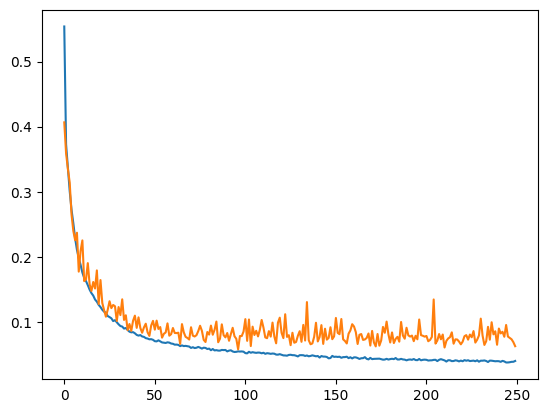

In [11]:
trainrnn(model,train_loader,test_loader,epochs = epochs,lr=1e-3,device='cpu',patience=5,factor=0.3, outmodelname = '../models/sequence_rnn.pkl')

In [134]:
model=joblib.load('../models/sequence_rnn.pkl')
summary(model);

Layer (type:depth-idx)                   Param #
├─RNN: 1-1                               1,120
├─Linear: 1-2                            29,925
Total params: 31,045
Trainable params: 31,045
Non-trainable params: 0


              precision    recall  f1-score   support

           0      0.991     0.969     0.980     18118
           1      0.579     0.833     0.683       556
           2      0.888     0.943     0.915      1448
           3      0.591     0.840     0.694       162
           4      0.975     0.975     0.975      1608

    accuracy                          0.963     21892
   macro avg      0.805     0.912     0.849     21892
weighted avg      0.970     0.963     0.966     21892



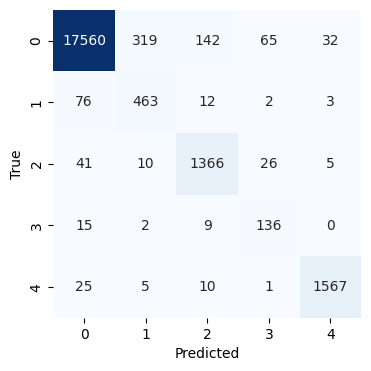

In [117]:
y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,val_loader)

table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

#### 1.2 Optimisation avec dropout

In [131]:
class RNNdrop(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_layer,num_classes=5,dropout=0.5):
        super(RNNdrop,self).__init__()
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.rnn=nn.RNN(input_size,hidden_size,num_layer,batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc=nn.Linear(hidden_size*187,num_classes)


    def forward(self,x):
        h0=torch.zeros(self.num_layer,x.size(0),self.hidden_size).to(device)
        out,_=self.rnn(x,h0)
        out=out.reshape(out.shape[0],-1)
        #out = self.dropout(out)
        out=self.fc(out)
        return out

In [135]:
model = RNNdrop(input_size, hidden_size,num_layer,num_classes)
summary(model);

Layer (type:depth-idx)                   Param #
├─RNN: 1-1                               1,120
├─Dropout: 1-2                           --
├─Linear: 1-3                            29,925
Total params: 31,045
Trainable params: 31,045
Non-trainable params: 0


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.5418028440559548, --- Val loss 0.4016799330711365, --- accuray : 0.8617621356922264, --- recall : 0.8606355564895782


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.36137361432912, --- Val loss 0.3428281247615814, --- accuray : 0.8934984688214452, --- recall : 0.8941537460211834


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.2961038973974965, --- Val loss 0.1890527606010437, --- accuray : 0.8967379357327356, --- recall : 0.8955990195666292


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.2636914933534748, --- Val loss 0.3484884798526764, --- accuray : 0.9148973402382286, --- recall : 0.9136878902642904


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 5/50 -- Training loss 0.2413618883056581, --- Val loss 0.1918456256389618, --- accuray : 0.9204443773938966, --- recall : 0.9203813654119063


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 6/50 -- Training loss 0.22458673092675427, --- Val loss 0.13226525485515594, --- accuray : 0.9215643927385229, --- recall : 0.922115305826049


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 7/50 -- Training loss 0.2120477301137473, --- Val loss 0.09836844354867935, --- accuray : 0.9345308269641244, --- recall : 0.9346814153525118


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 8/50 -- Training loss 0.19801096336765636, --- Val loss 0.07347659766674042, --- accuray : 0.9337080747206347, --- recall : 0.9340618094096025


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 9/50 -- Training loss 0.1906835973173787, --- Val loss 0.10946358740329742, --- accuray : 0.935405290682148, --- recall : 0.9350904648839891


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 10/50 -- Training loss 0.18260298564233335, --- Val loss 0.16562922298908234, --- accuray : 0.943572216838542, --- recall : 0.9437467647796567


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 11/50 -- Training loss 0.1742222689969446, --- Val loss 0.12001553922891617, --- accuray : 0.9340729429018559, --- recall : 0.9332601885409941


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 12/50 -- Training loss 0.16629968333535905, --- Val loss 0.1938537210226059, --- accuray : 0.944065295633456, --- recall : 0.9438285487304251


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 13/50 -- Training loss 0.1599529537650946, --- Val loss 0.22066177427768707, --- accuray : 0.941284385230564, --- recall : 0.9389552442113779


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 14/50 -- Training loss 0.15264936374231275, --- Val loss 0.13633126020431519, --- accuray : 0.9482481574485844, --- recall : 0.9480105687179783


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 15/50 -- Training loss 0.14695514925036143, --- Val loss 0.08674992620944977, --- accuray : 0.9459075906123184, --- recall : 0.945462949689821


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 16/50 -- Training loss 0.14242823935718837, --- Val loss 0.12089233100414276, --- accuray : 0.9545444648879771, --- recall : 0.9546331986542761


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 17/50 -- Training loss 0.13927015244528498, --- Val loss 0.050840262323617935, --- accuray : 0.9455298798632257, --- recall : 0.9453275441351969


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 18/50 -- Training loss 0.13495864672109537, --- Val loss 0.15444152057170868, --- accuray : 0.9547814846484352, --- recall : 0.9547120590807182


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 19/50 -- Training loss 0.13174752285756994, --- Val loss 0.050405655056238174, --- accuray : 0.946612555213961, --- recall : 0.9458062131697842


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 20/50 -- Training loss 0.1272433978750183, --- Val loss 0.02245328202843666, --- accuray : 0.9546095908102155, --- recall : 0.9544635513201604


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 21/50 -- Training loss 0.1262360625064363, --- Val loss 0.10790489614009857, --- accuray : 0.9602989465816993, --- recall : 0.960002309698304


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 22/50 -- Training loss 0.12237044517692514, --- Val loss 0.1187606230378151, --- accuray : 0.9479672742764427, --- recall : 0.947024047349658


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 23/50 -- Training loss 0.11970844135680093, --- Val loss 0.09294705837965012, --- accuray : 0.957788119133272, --- recall : 0.9574893386274272


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 24/50 -- Training loss 0.11650300595964452, --- Val loss 0.11395067721605301, --- accuray : 0.9600640518360924, --- recall : 0.9597580406379906


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 25/50 -- Training loss 0.11570483843655038, --- Val loss 0.11961217224597931, --- accuray : 0.958895344370509, --- recall : 0.9578426315011848


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 26/50 -- Training loss 0.11163015629189244, --- Val loss 0.09271784871816635, --- accuray : 0.9640681224087121, --- recall : 0.9641308424348163


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 27/50 -- Training loss 0.10952588945014807, --- Val loss 0.21547476947307587, --- accuray : 0.9629629579356841, --- recall : 0.9629589084059755


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 28/50 -- Training loss 0.10765723870649714, --- Val loss 0.05217071995139122, --- accuray : 0.9647926366155744, --- recall : 0.9647850322969382


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 29/50 -- Training loss 0.10547812822602257, --- Val loss 0.06260333955287933, --- accuray : 0.9623863839241935, --- recall : 0.9622656061908653


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 30/50 -- Training loss 0.1039054201867122, --- Val loss 0.13430291414260864, --- accuray : 0.958415556563893, --- recall : 0.9574187282201239


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 31/50 -- Training loss 0.10208195634874959, --- Val loss 0.08444888889789581, --- accuray : 0.9670719060581401, --- recall : 0.9670946582640573


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 32/50 -- Training loss 0.1002390349603791, --- Val loss 0.1394120454788208, --- accuray : 0.9643213940249936, --- recall : 0.964168282534082


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 33/50 -- Training loss 0.0985735932813239, --- Val loss 0.1330859512090683, --- accuray : 0.9597814814574311, --- recall : 0.9585436394875468


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 34/50 -- Training loss 0.09629262487411465, --- Val loss 0.07504095137119293, --- accuray : 0.9647451762242525, --- recall : 0.963923716082143


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 35/50 -- Training loss 0.09537734512602052, --- Val loss 0.05050138384103775, --- accuray : 0.9655210911979456, --- recall : 0.9655966029403492


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.09412392636494069, --- Val loss 0.14160776138305664, --- accuray : 0.9631909023009098, --- recall : 0.9632487756542965


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 37/50 -- Training loss 0.09411491056113791, --- Val loss 0.1152501031756401, --- accuray : 0.9703478698211437, --- recall : 0.970370798951645


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 38/50 -- Training loss 0.09172421879695561, --- Val loss 0.04313991963863373, --- accuray : 0.9721221907119318, --- recall : 0.9721997051414519


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 39/50 -- Training loss 0.09060439039223041, --- Val loss 0.22436460852622986, --- accuray : 0.9616324982871566, --- recall : 0.9594274877255545


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.08812497344357517, --- Val loss 0.05993419885635376, --- accuray : 0.9650845642442272, --- recall : 0.9645994804152046


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 41/50 -- Training loss 0.08740896190515592, --- Val loss 0.12433997541666031, --- accuray : 0.962213396735556, --- recall : 0.9600671457201866


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 42/50 -- Training loss 0.08543275033872876, --- Val loss 0.030658293515443802, --- accuray : 0.9690817107759381, --- recall : 0.9689455785240428


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 43/50 -- Training loss 0.08533406570586625, --- Val loss 0.07058911770582199, --- accuray : 0.9676614228757646, --- recall : 0.9675644065461274


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 44/50 -- Training loss 0.08401715124488954, --- Val loss 0.10207240283489227, --- accuray : 0.9594871029112477, --- recall : 0.958606140555917


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 45/50 -- Training loss 0.083038000011948, --- Val loss 0.07094541192054749, --- accuray : 0.9722811588713611, --- recall : 0.9716013329644614


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 46/50 -- Training loss 0.08193676545686249, --- Val loss 0.09149180352687836, --- accuray : 0.9693544336018715, --- recall : 0.9693821813610356


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 47/50 -- Training loss 0.08120642344343378, --- Val loss 0.11246352642774582, --- accuray : 0.9658524168324206, --- recall : 0.9656028396231868


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 48/50 -- Training loss 0.08027245490085991, --- Val loss 0.09887974709272385, --- accuray : 0.9688014819805513, --- recall : 0.9685860905797586


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.07927225741522813, --- Val loss 0.11618142575025558, --- accuray : 0.9691227707980904, --- recall : 0.9690569139438983


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 50/50 -- Training loss 0.07714998022935526, --- Val loss 0.09822225570678711, --- accuray : 0.9696996052060353, --- recall : 0.9696629078636356


RNNdrop(
  (rnn): RNN(1, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=5984, out_features=5, bias=True)
)

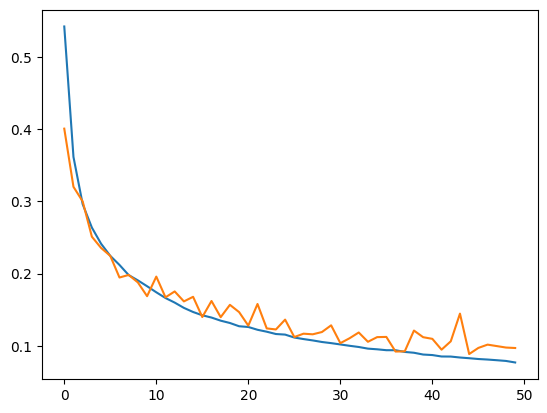

In [32]:
trainrnn(model,train_loader,test_loader,epochs = 50,lr=1e-3,device='cpu',patience=5,factor=0.3, outmodelname = '../models/sequence_rnn_withdropout.pkl')

In [136]:
model=joblib.load('../models/sequence_rnn_withdropout.pkl')
summary(model);

Layer (type:depth-idx)                   Param #
├─RNN: 1-1                               1,120
├─Dropout: 1-2                           --
├─Linear: 1-3                            29,925
Total params: 31,045
Trainable params: 31,045
Non-trainable params: 0


              precision    recall  f1-score   support

           0      0.990     0.965     0.977     18118
           1      0.559     0.772     0.648       556
           2      0.864     0.937     0.899      1448
           3      0.536     0.827     0.650       162
           4      0.961     0.979     0.970      1608

    accuracy                          0.958     21892
   macro avg      0.782     0.896     0.829     21892
weighted avg      0.965     0.958     0.961     21892



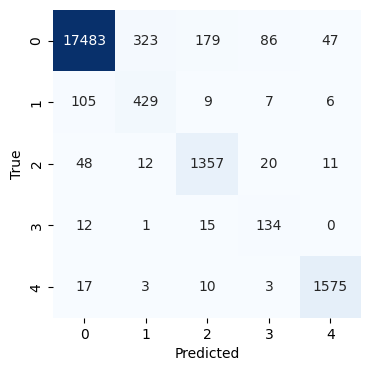

In [121]:
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, val_loader)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

## 2.GRU

#### 2.1 Optimisation sans dropout

In [127]:

#create RNN
class GRU(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_layer,num_classes=10):
        super(GRU,self).__init__()
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.rnn=nn.GRU(input_size,hidden_size,num_layer,batch_first=True)
        self.fc=nn.Linear(hidden_size*187,num_classes)


    def forward(self,x):
        h0=torch.zeros(self.num_layer,x.size(0),self.hidden_size).to(device)
        out,_=self.rnn(x,h0)
        out=out.reshape(out.shape[0],-1)
        out=self.fc(out)
        return out

In [128]:
model = GRU(input_size, hidden_size,num_layer,num_classes)
summary(model);

Layer (type:depth-idx)                   Param #
├─GRU: 1-1                               3,360
├─Linear: 1-2                            29,925
Total params: 33,285
Trainable params: 33,285
Non-trainable params: 0


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.47113239721090994, --- Val loss 0.3648522198200226, --- accuray : 0.8925442203883094, --- recall : 0.8923494606296763


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.2679995920793053, --- Val loss 0.21271030604839325, --- accuray : 0.91991140358629, --- recall : 0.9181986887154349


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.21371071565307176, --- Val loss 0.21928057074546814, --- accuray : 0.9331771316332272, --- recall : 0.9329831348725817


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.17654576506444483, --- Val loss 0.08001388609409332, --- accuray : 0.9432795991173014, --- recall : 0.9435227719912881


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 5/50 -- Training loss 0.1482275183756536, --- Val loss 0.18824107944965363, --- accuray : 0.9536120108483029, --- recall : 0.9533427117138945


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 6/50 -- Training loss 0.12813494489787822, --- Val loss 0.08228593319654465, --- accuray : 0.957671428533537, --- recall : 0.9577691546652372


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 7/50 -- Training loss 0.11419891089887546, --- Val loss 0.025080054998397827, --- accuray : 0.9581313608866383, --- recall : 0.9581165576381595


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 8/50 -- Training loss 0.10513630385200183, --- Val loss 0.04774152487516403, --- accuray : 0.9639634572300666, --- recall : 0.9639410982785043


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 9/50 -- Training loss 0.09643573856534303, --- Val loss 0.042240604758262634, --- accuray : 0.962440435965477, --- recall : 0.962300359531827


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 10/50 -- Training loss 0.0884482276570836, --- Val loss 0.06806369125843048, --- accuray : 0.963135898196198, --- recall : 0.9623873822221036


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 11/50 -- Training loss 0.08337121099907485, --- Val loss 0.24875149130821228, --- accuray : 0.9694143024934979, --- recall : 0.9690028642812696


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 12/50 -- Training loss 0.07781379836673961, --- Val loss 0.10117391496896744, --- accuray : 0.9759386470793153, --- recall : 0.9759084176660968


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 13/50 -- Training loss 0.07258759899302232, --- Val loss 0.058906495571136475, --- accuray : 0.9732408574516251, --- recall : 0.9731593280778922


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 14/50 -- Training loss 0.06868372120803372, --- Val loss 0.11698509007692337, --- accuray : 0.9749653684079235, --- recall : 0.9746946129557316


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 15/50 -- Training loss 0.06477370548599205, --- Val loss 0.03210482373833656, --- accuray : 0.9776888633022492, --- recall : 0.9775714635987081


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 16/50 -- Training loss 0.06168643986266975, --- Val loss 0.15774856507778168, --- accuray : 0.9760171911014572, --- recall : 0.9760254451877557


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 17/50 -- Training loss 0.059568266857646414, --- Val loss 0.02402455545961857, --- accuray : 0.9756305969778214, --- recall : 0.9755338181083127


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 18/50 -- Training loss 0.05610054471149651, --- Val loss 0.01972685381770134, --- accuray : 0.9785852008030673, --- recall : 0.9785326473588987


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 19/50 -- Training loss 0.053566232040356015, --- Val loss 0.03169241547584534, --- accuray : 0.977866376583366, --- recall : 0.9778637003610404


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 20/50 -- Training loss 0.05086606023189494, --- Val loss 0.023851724341511726, --- accuray : 0.9842850964654264, --- recall : 0.9843009820290142


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 21/50 -- Training loss 0.04870327533751438, --- Val loss 0.03691525757312775, --- accuray : 0.9838118887140386, --- recall : 0.983772769829401


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 22/50 -- Training loss 0.04781955144772321, --- Val loss 0.06802977621555328, --- accuray : 0.9813703172306676, --- recall : 0.9814250816107991


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 23/50 -- Training loss 0.045815836808530866, --- Val loss 0.06347349286079407, --- accuray : 0.9844410264051625, --- recall : 0.9844641771183428


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 24/50 -- Training loss 0.043774577807616524, --- Val loss 0.022338397800922394, --- accuray : 0.985689552575459, --- recall : 0.985670850056861


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 25/50 -- Training loss 0.043028297725960556, --- Val loss 0.013506552204489708, --- accuray : 0.9827084087915707, --- recall : 0.9827370631963204


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 26/50 -- Training loss 0.04102776651314393, --- Val loss 0.015532236546278, --- accuray : 0.9850232678884743, --- recall : 0.9850261593680785


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 27/50 -- Training loss 0.039210883897874374, --- Val loss 0.03674492612481117, --- accuray : 0.9850609749249266, --- recall : 0.9850532550384188


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 28/50 -- Training loss 0.038660088570215564, --- Val loss 0.10680974274873734, --- accuray : 0.9841930453475678, --- recall : 0.9840663564480077


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 29/50 -- Training loss 0.03651613303184969, --- Val loss 0.021124307066202164, --- accuray : 0.9856157984002939, --- recall : 0.9855720081751512


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 30/50 -- Training loss 0.036654302669782826, --- Val loss 0.09450224786996841, --- accuray : 0.9824401333343333, --- recall : 0.9822828703766817


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 31/50 -- Training loss 0.034800259368753736, --- Val loss 0.008097689598798752, --- accuray : 0.9853972105488165, --- recall : 0.9852829122918546


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 32/50 -- Training loss 0.034051729264270206, --- Val loss 0.01476370356976986, --- accuray : 0.9856359642364045, --- recall : 0.9856178055247214


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 33/50 -- Training loss 0.03240260195861962, --- Val loss 0.03577188774943352, --- accuray : 0.9882217435757539, --- recall : 0.9882198844281925


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 34/50 -- Training loss 0.03342117010605171, --- Val loss 0.013546604663133621, --- accuray : 0.9890227469120305, --- recall : 0.9890145457741802


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 35/50 -- Training loss 0.030465652633333087, --- Val loss 0.07758484780788422, --- accuray : 0.98713686538899, --- recall : 0.9870853362477666


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.031024859436419878, --- Val loss 0.01731644757091999, --- accuray : 0.9865812115359874, --- recall : 0.9865269271454086


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 37/50 -- Training loss 0.030054333669405516, --- Val loss 0.013001515530049801, --- accuray : 0.9891420547494132, --- recall : 0.98912995587669


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 38/50 -- Training loss 0.02877313817929518, --- Val loss 0.03892246633768082, --- accuray : 0.9872451222732372, --- recall : 0.9872671845716582


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 39/50 -- Training loss 0.028236477317711534, --- Val loss 0.05768803879618645, --- accuray : 0.9869403166718861, --- recall : 0.986874894819459


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.027624612886485652, --- Val loss 0.05836540833115578, --- accuray : 0.989020432363669, --- recall : 0.9890238077353178


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 41/50 -- Training loss 0.02680982055483192, --- Val loss 0.01064447220414877, --- accuray : 0.9885926002881614, --- recall : 0.9886206885040879


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 42/50 -- Training loss 0.026239366099074568, --- Val loss 0.004133508075028658, --- accuray : 0.9896954675672033, --- recall : 0.9897058387750821


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 43/50 -- Training loss 0.024959290960669334, --- Val loss 0.012202559038996696, --- accuray : 0.9901808317678065, --- recall : 0.9901771568011973


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 44/50 -- Training loss 0.02514678394208441, --- Val loss 0.006653227843344212, --- accuray : 0.9875900387135591, --- recall : 0.987615183407199


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 45/50 -- Training loss 0.024620040889735496, --- Val loss 0.003986708354204893, --- accuray : 0.9896988502754516, --- recall : 0.989701319830429


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 46/50 -- Training loss 0.02342485518140302, --- Val loss 0.0008047636947594583, --- accuray : 0.9899673209575184, --- recall : 0.9899747056180015


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 47/50 -- Training loss 0.023052536102931072, --- Val loss 0.05747642368078232, --- accuray : 0.9870547191123062, --- recall : 0.9870509751389995


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 48/50 -- Training loss 0.023191103962748958, --- Val loss 0.020204735919833183, --- accuray : 0.9902725729452433, --- recall : 0.9902928640732942


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.02277879596378141, --- Val loss 0.04187721386551857, --- accuray : 0.9886074250672447, --- recall : 0.9885785897156817


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 50/50 -- Training loss 0.022907472201827313, --- Val loss 0.03184057027101517, --- accuray : 0.9881908111280848, --- recall : 0.9882251421787187


GRU(
  (rnn): GRU(1, 32, batch_first=True)
  (fc): Linear(in_features=5984, out_features=5, bias=True)
)

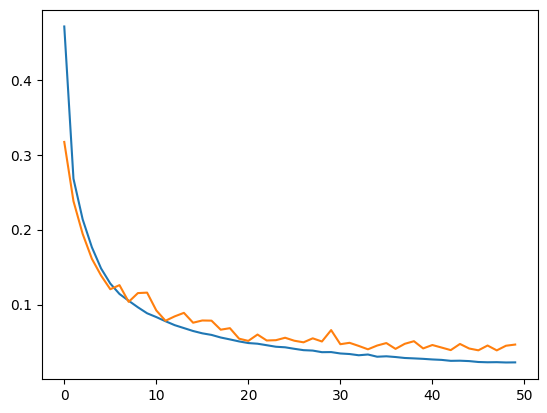

In [56]:
trainrnn(model,train_loader,test_loader,epochs = 50,lr=1e-3,device='cpu',patience=5,factor=0.3, outmodelname = '../models/sequence_gru.pkl')

In [129]:
model=joblib.load('../models/sequence_gru.pkl')
summary(model);

Layer (type:depth-idx)                   Param #
├─GRU: 1-1                               3,360
├─Linear: 1-2                            29,925
Total params: 33,285
Trainable params: 33,285
Non-trainable params: 0


              precision    recall  f1-score   support

           0      0.992     0.979     0.985     18118
           1      0.695     0.824     0.754       556
           2      0.931     0.943     0.937      1448
           3      0.613     0.852     0.713       162
           4      0.959     0.984     0.972      1608

    accuracy                          0.972     21892
   macro avg      0.838     0.916     0.872     21892
weighted avg      0.975     0.972     0.973     21892



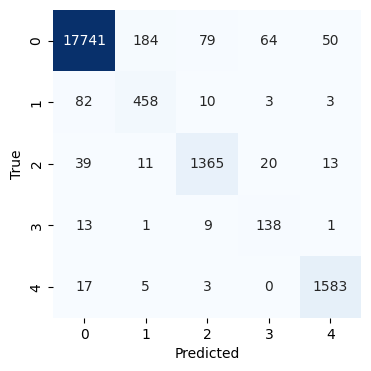

In [124]:
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, val_loader)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

## 3 . Application d'une couche RNN après une première couche de convolution

#### Base de données train et cross-val

Cette fois ci la dimension de la séquence est la troisième. un changement de dimension pour la couche RNN est appliquée dans le modèle

In [6]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')
X_train,X_cross, y_train, y_cross = train_test_split(X_train,y_train,test_size=split_size,random_state=12)

X_train =np.expand_dims(X_train,axis=1)
X_cross =np.expand_dims(X_cross,axis=1)
print(pd.Series(y_train).value_counts())
print(pd.Series(y_cross).value_counts())

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)


3.0    45023
2.0    45017
1.0    45001
4.0    44982
0.0    44977
Name: count, dtype: int64
0.0    5023
4.0    5018
1.0    4999
2.0    4983
3.0    4977
Name: count, dtype: int64


#### base de données test

In [63]:
X_val, y_val = load_balanced.load('../data/raw/mitbih_test.csv')
X_val = np.expand_dims(X_val,axis=1)
val_set = TensorDataset(torch.from_numpy(X_val).float(), torch.Tensor(torch.from_numpy(y_val).long()))
val_loader = DataLoader(val_set, batch_size=200, shuffle=False)

#### 3.1 Modèle CNN + RNN

In [8]:
class CNNRNN(nn.Module):
    
    def __init__(self,input_size,num_conv,hidden_size,num_layer,num_classes=10):
        super(CNNRNN,self).__init__()
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.num_conv =num_conv
        self.cnn =  nn.Conv1d(in_channels=1, out_channels=self.num_conv , kernel_size=7, stride=1, padding=0) # shape: (batch_size, n, 181)
        self.batch = nn.BatchNorm1d(num_features=self.num_conv )
        self.pool= nn.MaxPool1d(3, stride=3) # shape: (batch_size, n, 60)
        self.rnn=nn.RNN(self.num_conv ,hidden_size,num_layer,batch_first=True)
        self.fc=nn.Linear(hidden_size*60,num_classes)


    def forward(self,x):
        h0=torch.zeros(self.num_layer,x.size(0),self.hidden_size).to("cpu")
        out=self.cnn(x)
        
        out=nn.ReLU()(out)
        out=self.batch(out)
        out=self.pool(out)
        out,_=self.rnn(out.swapaxes(1,2),h0)
        out=out.reshape(out.shape[0],-1)
        out=self.fc(out)
        
        return out



In [138]:
model = CNNRNN(input_size,num_conv, hidden_size,num_layer,num_classes)


In [139]:
summary(model);

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            160
├─BatchNorm1d: 1-2                       40
├─MaxPool1d: 1-3                         --
├─RNN: 1-4                               1,728
├─Linear: 1-5                            9,605
Total params: 11,533
Trainable params: 11,533
Non-trainable params: 0


#### Train

C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 1/250 -- Training loss 0.01736026079380613, --- Val loss 0.01163922343403101, --- accuray : 0.9960013092125355, --- recall : 0.9960090488641627


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 2/250 -- Training loss 0.01613224435068922, --- Val loss 0.13021311163902283, --- accuray : 0.9959693644292381, --- recall : 0.9959707834008185


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 3/250 -- Training loss 0.017049695783130113, --- Val loss 0.039993442595005035, --- accuray : 0.9958075762846537, --- recall : 0.9958075892558551


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 4/250 -- Training loss 0.01635769701231588, --- Val loss 0.003145861905068159, --- accuray : 0.99639816998605, --- recall : 0.996407580193768


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 5/250 -- Training loss 0.015357465823740701, --- Val loss 0.00043024957994930446, --- accuray : 0.995879156042256, --- recall : 0.9958882792606512


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 6/250 -- Training loss 0.016170252315554436, --- Val loss 0.0013649269239977002, --- accuray : 0.9958474471937777, --- recall : 0.9958513018662561


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 7/250 -- Training loss 0.01574194075515157, --- Val loss 0.017501648515462875, --- accuray : 0.9958445342505666, --- recall : 0.9958526144280377


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 8/250 -- Training loss 0.015730598479273047, --- Val loss 0.001978627871721983, --- accuray : 0.9960427185229543, --- recall : 0.9960487934268517


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 9/250 -- Training loss 0.015290047261772216, --- Val loss 0.029870809987187386, --- accuray : 0.9955237646261257, --- recall : 0.9955316836416065


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 10/250 -- Training loss 0.014750277887028993, --- Val loss 0.08135589957237244, --- accuray : 0.9961615980678691, --- recall : 0.9961664175431345


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 11/250 -- Training loss 0.01559326651362999, --- Val loss 0.06801318377256393, --- accuray : 0.9958067559220233, --- recall : 0.9958102549242531


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 12/250 -- Training loss 0.01535783609371815, --- Val loss 0.009340835735201836, --- accuray : 0.9957689388135564, --- recall : 0.9957734860682784


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 13/250 -- Training loss 0.014831840972285747, --- Val loss 0.02681002765893936, --- accuray : 0.9950809904039645, --- recall : 0.9950893725841958


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 14/250 -- Training loss 0.014838370046953089, --- Val loss 0.03915310651063919, --- accuray : 0.9961700531721561, --- recall : 0.9961701277499821


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 15/250 -- Training loss 0.014386044788468996, --- Val loss 0.0008708062232472003, --- accuray : 0.9960459717852403, --- recall : 0.9960503861241692


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 16/250 -- Training loss 0.014931325444091485, --- Val loss 0.011193182319402695, --- accuray : 0.9961236570284899, --- recall : 0.996132145348346


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 17/250 -- Training loss 0.014166256377173048, --- Val loss 0.03326812759041786, --- accuray : 0.9961625508894354, --- recall : 0.9961706534713708


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 18/250 -- Training loss 0.01446465818859551, --- Val loss 0.005425443407148123, --- accuray : 0.9965237272924696, --- recall : 0.9965286157793856


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 19/250 -- Training loss 0.01450634121529085, --- Val loss 0.08483566343784332, --- accuray : 0.9954879368433304, --- recall : 0.9954857702407786


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 20/250 -- Training loss 0.014048984459207017, --- Val loss 0.00014479037781711668, --- accuray : 0.9951445169103689, --- recall : 0.995129626847589


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 21/250 -- Training loss 0.014961397019355026, --- Val loss 0.0001090700170607306, --- accuray : 0.9962461200687738, --- recall : 0.9962495987991682


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 22/250 -- Training loss 0.01402254102527045, --- Val loss 0.017873220145702362, --- accuray : 0.9956903695471386, --- recall : 0.9956903752457329


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 23/250 -- Training loss 0.014488716994193252, --- Val loss 0.011087700724601746, --- accuray : 0.9967682837945346, --- recall : 0.9967699628137066


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 24/250 -- Training loss 0.01318595461732982, --- Val loss 0.00038887173286639154, --- accuray : 0.9967228301455064, --- recall : 0.9967295264485891


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 25/250 -- Training loss 0.013641198244963909, --- Val loss 0.002449481748044491, --- accuray : 0.9966395309895123, --- recall : 0.9966468511030486


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 26/250 -- Training loss 0.013669846006710533, --- Val loss 0.09118475019931793, --- accuray : 0.9964019605254946, --- recall : 0.9964081808809941


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 27/250 -- Training loss 0.01282108985542105, --- Val loss 0.0016586253186687827, --- accuray : 0.996049577079196, --- recall : 0.996050385396158


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 28/250 -- Training loss 0.013509735460209452, --- Val loss 0.009158903732895851, --- accuray : 0.99644518988221, --- recall : 0.9964498814215595


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 29/250 -- Training loss 0.01333373165659651, --- Val loss 0.00030750068253837526, --- accuray : 0.9964445330279614, --- recall : 0.9964484030643532


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 30/250 -- Training loss 0.012776451536305066, --- Val loss 0.005274725612252951, --- accuray : 0.9964005673221298, --- recall : 0.996408326722716


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 31/250 -- Training loss 0.012342988838570485, --- Val loss 0.0011478641536086798, --- accuray : 0.9962882748163249, --- recall : 0.9962928736510142


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 32/250 -- Training loss 0.012772988692487948, --- Val loss 0.0022482520435005426, --- accuray : 0.9969617436356459, --- recall : 0.9969674829497407


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 33/250 -- Training loss 0.013722920588379948, --- Val loss 0.019080208614468575, --- accuray : 0.995221115527529, --- recall : 0.9952148709460522


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 34/250 -- Training loss 0.012138903984449246, --- Val loss 0.002248228993266821, --- accuray : 0.9961247931947076, --- recall : 0.9961327218945536


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 35/250 -- Training loss 0.013751456124393642, --- Val loss 0.0037206890992820263, --- accuray : 0.996481539587491, --- recall : 0.9964894610596426


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 36/250 -- Training loss 0.013770684726729704, --- Val loss 0.0269590113312006, --- accuray : 0.9965730106291988, --- recall : 0.9965715344953244


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 37/250 -- Training loss 0.011901054135917747, --- Val loss 0.001057245652191341, --- accuray : 0.9964867387465386, --- recall : 0.9964867638443428


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 38/250 -- Training loss 0.012602193157845384, --- Val loss 0.0002871509059332311, --- accuray : 0.9968009711012321, --- recall : 0.9968090204298756


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 39/250 -- Training loss 0.012439850106679102, --- Val loss 0.010975630953907967, --- accuray : 0.9961305549026729, --- recall : 0.9961324967047996


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 40/250 -- Training loss 0.012858266323803555, --- Val loss 0.008275266736745834, --- accuray : 0.9955645842539823, --- recall : 0.9955690221325266


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 41/250 -- Training loss 0.012540676746629266, --- Val loss 0.001853753114119172, --- accuray : 0.9963242809336987, --- recall : 0.996330247673926


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 42/250 -- Training loss 0.01187961484182457, --- Val loss 0.0027565835043787956, --- accuray : 0.9959294616825265, --- recall : 0.9959303757017219


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 43/250 -- Training loss 0.01260338598940269, --- Val loss 0.004580193664878607, --- accuray : 0.9951734282310595, --- recall : 0.995171273358482


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 44/250 -- Training loss 0.012667854011310743, --- Val loss 0.0018032861407846212, --- accuray : 0.9961677063535553, --- recall : 0.9961717996525241


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 45/250 -- Training loss 0.011861402244318094, --- Val loss 0.00033015303779393435, --- accuray : 0.9960532600507024, --- recall : 0.9960534444359943


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 46/250 -- Training loss 0.012348881699007268, --- Val loss 0.010161623358726501, --- accuray : 0.9971630568761629, --- recall : 0.9971689813612459


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 47/250 -- Training loss 0.011857225091230005, --- Val loss 0.03820834681391716, --- accuray : 0.9963634060031719, --- recall : 0.9963682308488645


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 48/250 -- Training loss 0.011315309351273306, --- Val loss 0.00026420020731166005, --- accuray : 0.9960161603694748, --- recall : 0.99601246019069


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 49/250 -- Training loss 0.012291770748358449, --- Val loss 0.0016914018196985126, --- accuray : 0.9957330429293648, --- recall : 0.9957350675069172


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 50/250 -- Training loss 0.012238080175795385, --- Val loss 0.03803693875670433, --- accuray : 0.9954640046984669, --- recall : 0.9954567025786576


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 51/250 -- Training loss 0.01121347069449435, --- Val loss 0.0015421300195157528, --- accuray : 0.9962444543214272, --- recall : 0.9962505465196589


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 52/250 -- Training loss 0.011419898849291156, --- Val loss 0.22776421904563904, --- accuray : 0.9964461541342136, --- recall : 0.9964476179344339


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 53/250 -- Training loss 0.011014747329540242, --- Val loss 0.0027113775722682476, --- accuray : 0.9969196862220133, --- recall : 0.9969253691293254


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 54/250 -- Training loss 0.010799860648094947, --- Val loss 0.001083117094822228, --- accuray : 0.9966466941519849, --- recall : 0.9966523839694869


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 55/250 -- Training loss 0.011211157884077172, --- Val loss 0.0006881587905809283, --- accuray : 0.9964465384519512, --- recall : 0.9964498235948966


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 56/250 -- Training loss 0.010810633899487622, --- Val loss 0.00439839530736208, --- accuray : 0.9957253134098771, --- recall : 0.9957289351168799


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 57/250 -- Training loss 0.011644510795627635, --- Val loss 0.006441453471779823, --- accuray : 0.9967607738603524, --- recall : 0.9967684335410991


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 58/250 -- Training loss 0.01054817820308942, --- Val loss 0.0004331652307882905, --- accuray : 0.9965251482957254, --- recall : 0.9965307991904677


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 59/250 -- Training loss 0.01141874364419497, --- Val loss 0.00772239500656724, --- accuray : 0.9958849485053525, --- recall : 0.9958893929124398


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 60/250 -- Training loss 0.01031219513120117, --- Val loss 0.0011454086052253842, --- accuray : 0.9964065647065261, --- recall : 0.996410021745457


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 61/250 -- Training loss 0.01120894567759543, --- Val loss 0.024141503497958183, --- accuray : 0.9964464049726531, --- recall : 0.9964513423541301


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 62/250 -- Training loss 0.010921721512031591, --- Val loss 0.03241385519504547, --- accuray : 0.9972813439655068, --- recall : 0.9972873992744745


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 63/250 -- Training loss 0.011417762957239239, --- Val loss 0.0005054935463704169, --- accuray : 0.9969623422916746, --- recall : 0.9969679563972225


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 64/250 -- Training loss 0.011252567204753485, --- Val loss 0.001849789172410965, --- accuray : 0.9965610114963959, --- recall : 0.9965696999116285


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 65/250 -- Training loss 0.010549845447279332, --- Val loss 0.0024916580878198147, --- accuray : 0.996051873921121, --- recall : 0.9960539639288412


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 66/250 -- Training loss 0.01052956110037903, --- Val loss 0.00014116568490862846, --- accuray : 0.9970848521279422, --- recall : 0.9970895618579556


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 67/250 -- Training loss 0.010371642810633758, --- Val loss 0.024280425161123276, --- accuray : 0.996799015145486, --- recall : 0.9968075484440186


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 68/250 -- Training loss 0.010356120190372332, --- Val loss 0.0009057207498699427, --- accuray : 0.9966027088552897, --- recall : 0.9966089085182359


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 69/250 -- Training loss 0.011018308042444299, --- Val loss 0.0010731222573667765, --- accuray : 0.9963703236210518, --- recall : 0.9963715310923591


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 70/250 -- Training loss 0.010749814500255406, --- Val loss 0.016654428094625473, --- accuray : 0.9964882714997753, --- recall : 0.996488561823002


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 71/250 -- Training loss 0.0103950076632972, --- Val loss 0.006256989203393459, --- accuray : 0.9967647500770314, --- recall : 0.996770019139056


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 72/250 -- Training loss 0.010185546736330223, --- Val loss 0.007400743663311005, --- accuray : 0.9972394088465611, --- recall : 0.9972477393269582


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 73/250 -- Training loss 0.010626846461683303, --- Val loss 0.014387542381882668, --- accuray : 0.9966850335937407, --- recall : 0.9966907058034714


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 74/250 -- Training loss 0.010468770989008972, --- Val loss 0.000499034533277154, --- accuray : 0.9966500658619146, --- recall : 0.9966526378252615


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 75/250 -- Training loss 0.010166420749133827, --- Val loss 0.0018467006739228964, --- accuray : 0.9972038624311313, --- recall : 0.9972079511504546


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 76/250 -- Training loss 0.01016893647723933, --- Val loss 0.00011380543583072722, --- accuray : 0.9972414526640472, --- recall : 0.997248318447524


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 77/250 -- Training loss 0.010031061036123414, --- Val loss 0.0006433710805140436, --- accuray : 0.9965269052105761, --- recall : 0.996529569090989


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 78/250 -- Training loss 0.010388652529222166, --- Val loss 0.0007533399621024728, --- accuray : 0.9951395125635798, --- recall : 0.9951319585841689


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 79/250 -- Training loss 0.0104161292707308, --- Val loss 0.03904423490166664, --- accuray : 0.9963606485390812, --- recall : 0.996369291941131


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 80/250 -- Training loss 0.00992422223046134, --- Val loss 0.0024714504834264517, --- accuray : 0.9970840429888428, --- recall : 0.9970857532724168


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 81/250 -- Training loss 0.010598647540724771, --- Val loss 0.006475251633673906, --- accuray : 0.9963614050311088, --- recall : 0.9963706101009595


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 82/250 -- Training loss 0.009816128471351241, --- Val loss 0.004026962444186211, --- accuray : 0.9971235504263136, --- recall : 0.997129090040725


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 83/250 -- Training loss 0.010102587041408085, --- Val loss 0.03496476262807846, --- accuray : 0.9973215115340143, --- recall : 0.9973284319061125


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 84/250 -- Training loss 0.009821188388400126, --- Val loss 0.013059343211352825, --- accuray : 0.9963645589186838, --- recall : 0.9963734035037237


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 85/250 -- Training loss 0.01059390872612169, --- Val loss 0.0010677296668291092, --- accuray : 0.9964488259788741, --- recall : 0.9964519555053739


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 86/250 -- Training loss 0.009252131056352697, --- Val loss 0.00024804536951705813, --- accuray : 0.9969641220891832, --- recall : 0.99696808179062


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 87/250 -- Training loss 0.009929252537547777, --- Val loss 0.024988284334540367, --- accuray : 0.9970418513521142, --- recall : 0.997049146129261


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 88/250 -- Training loss 0.009835501247313827, --- Val loss 0.001787760411389172, --- accuray : 0.9961741988341469, --- recall : 0.9961711683939246


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 89/250 -- Training loss 0.010008609640717767, --- Val loss 0.06530396640300751, --- accuray : 0.9968447522945081, --- recall : 0.9968475042622942


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 90/250 -- Training loss 0.009751922944370387, --- Val loss 0.011292015202343464, --- accuray : 0.9963715443118586, --- recall : 0.9963685347492215


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 91/250 -- Training loss 0.009335651440610609, --- Val loss 0.00021847127936780453, --- accuray : 0.9968042741126556, --- recall : 0.9968085922997482


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 92/250 -- Training loss 0.009672422641013605, --- Val loss 0.0008485654834657907, --- accuray : 0.9962497686591947, --- recall : 0.9962515697842569


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 93/250 -- Training loss 0.008919677711970194, --- Val loss 0.005298924166709185, --- accuray : 0.9968877419753108, --- recall : 0.9968896925154145


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 94/250 -- Training loss 0.009760212274249407, --- Val loss 0.057036712765693665, --- accuray : 0.9972844322279044, --- recall : 0.9972891077367615


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 95/250 -- Training loss 0.009198126824340907, --- Val loss 0.00022813116083852947, --- accuray : 0.9962073445279949, --- recall : 0.9962133604893271


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 96/250 -- Training loss 0.009834234602265112, --- Val loss 0.0027402671985328197, --- accuray : 0.997003441544304, --- recall : 0.9970073053903121


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 97/250 -- Training loss 0.009362332450681719, --- Val loss 0.00928177498281002, --- accuray : 0.9962886065627684, --- recall : 0.9962917950365956


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 98/250 -- Training loss 0.009001552716444993, --- Val loss 6.831223436165601e-05, --- accuray : 0.9971246314837175, --- recall : 0.9971300972914184


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 99/250 -- Training loss 0.009417594594743575, --- Val loss 0.005401101894676685, --- accuray : 0.9972414868576074, --- recall : 0.9972486777429934


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 100/250 -- Training loss 0.009618480993532776, --- Val loss 0.0177312009036541, --- accuray : 0.9952630892240641, --- recall : 0.9952567482900374


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 101/250 -- Training loss 0.009419424977854671, --- Val loss 0.0004147868894506246, --- accuray : 0.9968883991018865, --- recall : 0.9968905713037307


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 102/250 -- Training loss 0.009511816798328231, --- Val loss 0.00230787112377584, --- accuray : 0.9968884913513957, --- recall : 0.9968905173193499


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 103/250 -- Training loss 0.00945097805871136, --- Val loss 0.0018530070083215833, --- accuray : 0.9966806194680615, --- recall : 0.996688312098204


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 104/250 -- Training loss 0.009511726799989299, --- Val loss 0.024740632623434067, --- accuray : 0.9973623801744296, --- recall : 0.9973685192557451


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 105/250 -- Training loss 0.009450453632700738, --- Val loss 0.0014610530342906713, --- accuray : 0.9969648275951684, --- recall : 0.9969682586393309


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 106/250 -- Training loss 0.008921758338049899, --- Val loss 0.015246734954416752, --- accuray : 0.9972490535233707, --- recall : 0.997250889001503


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 107/250 -- Training loss 0.008830239061437047, --- Val loss 2.5983568775700405e-05, --- accuray : 0.9969632795583966, --- recall : 0.9969688494959034


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 108/250 -- Training loss 0.009192735872560075, --- Val loss 0.0006075577111914754, --- accuray : 0.9968443500823077, --- recall : 0.9968494386423462


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 109/250 -- Training loss 0.009035186614913572, --- Val loss 0.05429956689476967, --- accuray : 0.9964110605918755, --- recall : 0.9964131402702048


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 110/250 -- Training loss 0.00917354749628432, --- Val loss 0.0006349841714836657, --- accuray : 0.9965204100786155, --- recall : 0.9965279794626515


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 111/250 -- Training loss 0.008758650041589764, --- Val loss 0.007631019689142704, --- accuray : 0.9974001467653559, --- recall : 0.9974044292318153


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 112/250 -- Training loss 0.008779687118109891, --- Val loss 0.009147637523710728, --- accuray : 0.9970844818879611, --- recall : 0.9970883460235507


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 113/250 -- Training loss 0.00862974573717956, --- Val loss 0.004396696109324694, --- accuray : 0.9968060555375671, --- recall : 0.9968098620732428


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 114/250 -- Training loss 0.009199182963210421, --- Val loss 0.00017060495156329125, --- accuray : 0.9964525049288013, --- recall : 0.996453482203623


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 115/250 -- Training loss 0.009360035670793755, --- Val loss 0.0008196012349799275, --- accuray : 0.997361627030954, --- recall : 0.9973675683756923


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 116/250 -- Training loss 0.008870690876062147, --- Val loss 0.003223504638299346, --- accuray : 0.9968845673770902, --- recall : 0.9968902380999239


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 117/250 -- Training loss 0.009196916297894474, --- Val loss 0.007281077094376087, --- accuray : 0.9971233015387584, --- recall : 0.9971296752992505


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 118/250 -- Training loss 0.008573381312296562, --- Val loss 0.006758140400052071, --- accuray : 0.9972806497160688, --- recall : 0.9972877442595788


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 119/250 -- Training loss 0.009657419205803461, --- Val loss 0.007246790453791618, --- accuray : 0.9966478004643919, --- recall : 0.9966524236435029


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 120/250 -- Training loss 0.008427878393562873, --- Val loss 0.00011158092820551246, --- accuray : 0.9966481010926296, --- recall : 0.9966516448396419


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 121/250 -- Training loss 0.008840519364676207, --- Val loss 0.012595965526998043, --- accuray : 0.9961763971556635, --- recall : 0.9961752267001476


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 122/250 -- Training loss 0.009062553979143906, --- Val loss 0.0005123520968481898, --- accuray : 0.9973223352667914, --- recall : 0.9973286707235113


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 123/250 -- Training loss 0.008291939786524217, --- Val loss 0.001947085838764906, --- accuray : 0.9962085944297024, --- recall : 0.9962112024871873


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 124/250 -- Training loss 0.0091186651932061, --- Val loss 0.00032232454395852983, --- accuray : 0.9970435460071563, --- recall : 0.99704872905242


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 125/250 -- Training loss 0.008572215937424625, --- Val loss 0.0686463713645935, --- accuray : 0.9966875027224269, --- recall : 0.9966906827807888


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 126/250 -- Training loss 0.009176853848356405, --- Val loss 0.00016928381228353828, --- accuray : 0.9964491490279184, --- recall : 0.9964532593548376


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 127/250 -- Training loss 0.00921082685960338, --- Val loss 0.023838739842176437, --- accuray : 0.9972066239826114, --- recall : 0.9972100909999476


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 128/250 -- Training loss 0.008326201603166291, --- Val loss 0.000679346383549273, --- accuray : 0.9971656257403302, --- recall : 0.9971701052930187


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 129/250 -- Training loss 0.008424162327053408, --- Val loss 9.55322029767558e-05, --- accuray : 0.9970418517995769, --- recall : 0.997049097060207


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 130/250 -- Training loss 0.008532927349200529, --- Val loss 0.00048252844135276973, --- accuray : 0.997521392940658, --- recall : 0.9975243602609393


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 131/250 -- Training loss 0.009268516741283503, --- Val loss 0.060335393995046616, --- accuray : 0.9972455302548223, --- recall : 0.9972510174638801


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 132/250 -- Training loss 0.008041571952167141, --- Val loss 0.0007999183144420385, --- accuray : 0.9967236416148955, --- recall : 0.9967303450692737


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 133/250 -- Training loss 0.008475472553413707, --- Val loss 0.0001886978279799223, --- accuray : 0.997045100165748, --- recall : 0.9970500416142019


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 134/250 -- Training loss 0.009005628243609492, --- Val loss 0.0017357474425807595, --- accuray : 0.9965674696407799, --- recall : 0.9965704011232225


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 135/250 -- Training loss 0.00835632138319227, --- Val loss 0.0009140938054770231, --- accuray : 0.9974422154880074, --- recall : 0.9974485519555703


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 136/250 -- Training loss 0.008708385274595033, --- Val loss 0.003178833983838558, --- accuray : 0.9970415649850819, --- recall : 0.9970463742931575


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 137/250 -- Training loss 0.008211355692021784, --- Val loss 0.001707002054899931, --- accuray : 0.997085910772238, --- recall : 0.9970903288352279


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 138/250 -- Training loss 0.008334056910322386, --- Val loss 0.00521255936473608, --- accuray : 0.9971233817356884, --- recall : 0.9971286022828787


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 139/250 -- Training loss 0.007968168988039145, --- Val loss 0.00010188567102886736, --- accuray : 0.9975590364743907, --- recall : 0.9975668785513705


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 140/250 -- Training loss 0.008648723368605017, --- Val loss 0.07907463610172272, --- accuray : 0.9971614889501087, --- recall : 0.9971681105572363


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 141/250 -- Training loss 0.009116526035606214, --- Val loss 0.040182989090681076, --- accuray : 0.9965283783290237, --- recall : 0.9965296087650051


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 142/250 -- Training loss 0.007759643030153137, --- Val loss 0.0014251929242163897, --- accuray : 0.996849565160767, --- recall : 0.9968511081586284


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 143/250 -- Training loss 0.008327231573528493, --- Val loss 0.0001843820500653237, --- accuray : 0.9966871854002601, --- recall : 0.996691841516542


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 144/250 -- Training loss 0.00858725437429987, --- Val loss 0.0004336117417551577, --- accuray : 0.996884780908518, --- recall : 0.9968880540061216


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 145/250 -- Training loss 0.00843478924288831, --- Val loss 0.0005899216630496085, --- accuray : 0.996845510610583, --- recall : 0.9968506116884642


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 146/250 -- Training loss 0.008246678435418715, --- Val loss 0.0005872983019798994, --- accuray : 0.9969639519597152, --- recall : 0.9969699511330047


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 147/250 -- Training loss 0.008117641645214588, --- Val loss 0.020859338343143463, --- accuray : 0.9973233693122412, --- recall : 0.997328654072178


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 148/250 -- Training loss 0.008170701781176338, --- Val loss 0.00043161155190318823, --- accuray : 0.9968813901635546, --- recall : 0.9968897122810187


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 149/250 -- Training loss 0.008375896415272439, --- Val loss 0.002393921371549368, --- accuray : 0.9973239716031248, --- recall : 0.9973289824059488


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 150/250 -- Training loss 0.008617317607958084, --- Val loss 0.0009384658187627792, --- accuray : 0.9968804722604183, --- recall : 0.9968878610459896


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 151/250 -- Training loss 0.008206263357491618, --- Val loss 1.0098040547745768e-05, --- accuray : 0.9967254463332808, --- recall : 0.9967315465480228


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 152/250 -- Training loss 0.008361572732253414, --- Val loss 0.0008676679572090507, --- accuray : 0.9971662256921437, --- recall : 0.9971701544073639


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 153/250 -- Training loss 0.007970772495761166, --- Val loss 0.06821822375059128, --- accuray : 0.996882157783185, --- recall : 0.9968894870459737


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 154/250 -- Training loss 0.008240879660328925, --- Val loss 0.0009392559295520186, --- accuray : 0.997002029009168, --- recall : 0.9970082182545974


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 155/250 -- Training loss 0.00729052178121699, --- Val loss 8.216733840527013e-05, --- accuray : 0.9971615990608811, --- recall : 0.9971680360792401


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 156/250 -- Training loss 0.007832750918543857, --- Val loss 0.03069130890071392, --- accuray : 0.9971271495994859, --- recall : 0.9971300972914184


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 157/250 -- Training loss 0.008433629274711819, --- Val loss 0.0003684198309201747, --- accuray : 0.9976412528366347, --- recall : 0.9976470682890113


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 158/250 -- Training loss 0.007558267143790038, --- Val loss 0.00036660756450146437, --- accuray : 0.9974004255286764, --- recall : 0.9974080989391194


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 159/250 -- Training loss 0.008809821059864291, --- Val loss 3.423636144361808e-06, --- accuray : 0.9964166772021169, --- recall : 0.9964147440208085


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 160/250 -- Training loss 0.008401472979789795, --- Val loss 0.07377605140209198, --- accuray : 0.9967727643959678, --- recall : 0.9967712175488253


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 161/250 -- Training loss 0.008250965457746723, --- Val loss 0.0003428481286391616, --- accuray : 0.9964857322736022, --- recall : 0.9964923092200898


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 162/250 -- Training loss 0.007965840267527594, --- Val loss 0.0003551824775058776, --- accuray : 0.9966048868493207, --- recall : 0.9966122728691607


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 163/250 -- Training loss 0.008035778672872525, --- Val loss 0.0007031516288407147, --- accuray : 0.9972433652608117, --- recall : 0.9972503639106088


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 164/250 -- Training loss 0.008426592004446551, --- Val loss 0.0021152710542082787, --- accuray : 0.9968505667041334, --- recall : 0.9968529117353351


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 165/250 -- Training loss 0.007314248191803086, --- Val loss 0.0013640148099511862, --- accuray : 0.9970451312361929, --- recall : 0.9970500955985825


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 166/250 -- Training loss 0.007940239202720627, --- Val loss 0.00042094572563655674, --- accuray : 0.9968836592080876, --- recall : 0.9968899177504597


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 167/250 -- Training loss 0.008209510204780203, --- Val loss 0.0013560970546677709, --- accuray : 0.9967642259261925, --- recall : 0.9967704045261877


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 168/250 -- Training loss 0.007651711700608927, --- Val loss 0.002689376240596175, --- accuray : 0.9972449118647624, --- recall : 0.9972489085760854


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 169/250 -- Training loss 0.00806956701670987, --- Val loss 0.0034087030217051506, --- accuray : 0.9970862507441162, --- recall : 0.9970898807513976


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 170/250 -- Training loss 0.007351894109656593, --- Val loss 2.4990809833980165e-05, --- accuray : 0.9969252576219196, --- recall : 0.9969292865091537


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 171/250 -- Training loss 0.008218298453654635, --- Val loss 0.0022302602883428335, --- accuray : 0.9972462115296608, --- recall : 0.9972505550696849


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 172/250 -- Training loss 0.007902214635434841, --- Val loss 0.0007363275508396327, --- accuray : 0.9972829830011104, --- recall : 0.997288574661561


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 173/250 -- Training loss 0.008154376277606823, --- Val loss 0.00013429646787699312, --- accuray : 0.9972411613505165, --- recall : 0.997247773591026


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 174/250 -- Training loss 0.007614083028454077, --- Val loss 6.03532898821868e-05, --- accuray : 0.9966879238155958, --- recall : 0.9966916012431211


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 175/250 -- Training loss 0.00773463918294981, --- Val loss 0.004734559915959835, --- accuray : 0.9973247400580206, --- recall : 0.9973293726631164


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 176/250 -- Training loss 0.008078506993641956, --- Val loss 0.04075482860207558, --- accuray : 0.9974065653654313, --- recall : 0.9974091491209072


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 177/250 -- Training loss 0.007847622921724348, --- Val loss 0.003477462800219655, --- accuray : 0.9966832858106217, --- recall : 0.9966877030889847


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 178/250 -- Training loss 0.008388797436774917, --- Val loss 0.05985383689403534, --- accuray : 0.996603182995397, --- recall : 0.9966103527541822


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 179/250 -- Training loss 0.0075643284996755105, --- Val loss 0.00806239154189825, --- accuray : 0.9973603168486779, --- recall : 0.9973669155504326


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 180/250 -- Training loss 0.008441197511869962, --- Val loss 0.00038453942397609353, --- accuray : 0.9963653240965685, --- recall : 0.9963703357515696


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 181/250 -- Training loss 0.007123363867100423, --- Val loss 0.031151827424764633, --- accuray : 0.9969280366451247, --- recall : 0.996932482723685


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 182/250 -- Training loss 0.007648212383819203, --- Val loss 0.0028649333398789167, --- accuray : 0.9967269489693813, --- recall : 0.9967309700018152


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 183/250 -- Training loss 0.00726959851367874, --- Val loss 0.004786208271980286, --- accuray : 0.9972403664603784, --- recall : 0.99724659490157


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 184/250 -- Training loss 0.007683021281836183, --- Val loss 4.3633117456920445e-05, --- accuray : 0.996294230104167, --- recall : 0.9962941347574823


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 185/250 -- Training loss 0.007035454872287476, --- Val loss 0.015055169351398945, --- accuray : 0.9970032041934991, --- recall : 0.9970083871190019


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 186/250 -- Training loss 0.008163382094325107, --- Val loss 2.2187401555129327e-05, --- accuray : 0.9970093079011958, --- recall : 0.9970110147716322


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 187/250 -- Training loss 0.007405314109097013, --- Val loss 9.141290502157062e-05, --- accuray : 0.9971252869235638, --- recall : 0.9971300489050845


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 188/250 -- Training loss 0.008084344997756612, --- Val loss 0.029708929359912872, --- accuray : 0.9971282806260504, --- recall : 0.9971309760797344


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 189/250 -- Training loss 0.007769834376053022, --- Val loss 0.002942728577181697, --- accuray : 0.9966069104321319, --- recall : 0.9966125441042799


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 190/250 -- Training loss 0.0074444871514645124, --- Val loss 1.6169431546586566e-05, --- accuray : 0.9971619723222218, --- recall : 0.9971686530274748


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 191/250 -- Training loss 0.007416308404942482, --- Val loss 0.0002167887578252703, --- accuray : 0.9968010148502433, --- recall : 0.9968087547928034


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 192/250 -- Training loss 0.007028326817602977, --- Val loss 0.00937195960432291, --- accuray : 0.997201384675652, --- recall : 0.9972068574523687


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 193/250 -- Training loss 0.008078418882355404, --- Val loss 0.0009671614388935268, --- accuray : 0.9970464179280336, --- recall : 0.9970499354464961


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 194/250 -- Training loss 0.007511553199675105, --- Val loss 0.004371837712824345, --- accuray : 0.997400834060112, --- recall : 0.9974073486131804


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 195/250 -- Training loss 0.008166050492778062, --- Val loss 9.383766155224293e-05, --- accuray : 0.9974013738301659, --- recall : 0.997407842742376


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 196/250 -- Training loss 0.007048496335959606, --- Val loss 0.0006232152227312326, --- accuray : 0.997641581338869, --- recall : 0.9976474766988256


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 197/250 -- Training loss 0.007790837337361959, --- Val loss 0.0022402391768991947, --- accuray : 0.997720949405846, --- recall : 0.9977277043547176


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 198/250 -- Training loss 0.007353704480785865, --- Val loss 0.0009960897732526064, --- accuray : 0.9972057727859174, --- recall : 0.9972094740517129


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 199/250 -- Training loss 0.00725132970789331, --- Val loss 5.498317113961093e-05, --- accuray : 0.9968878767003423, --- recall : 0.9968904769173225


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 200/250 -- Training loss 0.007261562099281132, --- Val loss 0.001497530611231923, --- accuray : 0.9975634491956671, --- recall : 0.9975689613475028


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 201/250 -- Training loss 0.00805345379325835, --- Val loss 0.00029688040376640856, --- accuray : 0.9974034302249535, --- recall : 0.9974084955676361


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 202/250 -- Training loss 0.007681739294218953, --- Val loss 2.1801508410135284e-05, --- accuray : 0.9969622625725568, --- recall : 0.9969682617083107


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 203/250 -- Training loss 0.007256930834990631, --- Val loss 0.0005547388573177159, --- accuray : 0.9970495273681808, --- recall : 0.9970513423946858


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 204/250 -- Training loss 0.00786342905518078, --- Val loss 0.0006129977409727871, --- accuray : 0.997479276244885, --- recall : 0.9974870964502417


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 205/250 -- Training loss 0.007641206241745026, --- Val loss 9.21787341212621e-06, --- accuray : 0.9972484843145949, --- recall : 0.9972494193566144


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 206/250 -- Training loss 0.0072448654894723165, --- Val loss 0.00011486361472634599, --- accuray : 0.9966868737419208, --- recall : 0.9966898746734782


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 207/250 -- Training loss 0.007393768404615051, --- Val loss 0.010143844410777092, --- accuray : 0.9974859937437788, --- recall : 0.9974887915182737


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 208/250 -- Training loss 0.007038840911291252, --- Val loss 0.018602829426527023, --- accuray : 0.9974428911186347, --- recall : 0.997449080115444


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 209/250 -- Training loss 0.007152831387228625, --- Val loss 5.416019484982826e-05, --- accuray : 0.9974044173070062, --- recall : 0.9974078396281053


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 210/250 -- Training loss 0.007551004477428636, --- Val loss 0.0002765562676358968, --- accuray : 0.9966013507148656, --- recall : 0.9966087117158221


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 211/250 -- Training loss 0.006951314677475727, --- Val loss 0.060479141771793365, --- accuray : 0.997519878493079, --- recall : 0.9975253271548965


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 212/250 -- Training loss 0.007437279101998429, --- Val loss 0.00044471729779616, --- accuray : 0.9975247636367236, --- recall : 0.9975284092174155


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 213/250 -- Training loss 0.007017516105841643, --- Val loss 0.0008160446886904538, --- accuray : 0.9971665249861597, --- recall : 0.9971697856715658


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 214/250 -- Training loss 0.007504306942386492, --- Val loss 0.03766588121652603, --- accuray : 0.9970822385490052, --- recall : 0.9970893706988797


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 215/250 -- Training loss 0.006959241481182974, --- Val loss 0.006646953988820314, --- accuray : 0.9968065396976108, --- recall : 0.996811114467393


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 216/250 -- Training loss 0.0074612551487455965, --- Val loss 0.011917372234165668, --- accuray : 0.9969659880250159, --- recall : 0.9969688321165588


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 217/250 -- Training loss 0.007061630602991689, --- Val loss 0.0325046107172966, --- accuray : 0.9968095723500273, --- recall : 0.9968128894233697


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 218/250 -- Training loss 0.007477315128596147, --- Val loss 0.005309612490236759, --- accuray : 0.9971232179083227, --- recall : 0.9971293643901152


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 219/250 -- Training loss 0.0071734441741779335, --- Val loss 0.004082414787262678, --- accuray : 0.9971269825416501, --- recall : 0.9971300799120739


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 220/250 -- Training loss 0.007395867800269119, --- Val loss 0.000498808512929827, --- accuray : 0.9973635871165755, --- recall : 0.9973697660518482


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 221/250 -- Training loss 0.007431060169514701, --- Val loss 0.028329525142908096, --- accuray : 0.9966097039483091, --- recall : 0.9966121991191754


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 222/250 -- Training loss 0.006510350504992355, --- Val loss 0.00018275984621141106, --- accuray : 0.9972872190376627, --- recall : 0.9972892758731549


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 223/250 -- Training loss 0.0073088852651388946, --- Val loss 0.0023762884084135294, --- accuray : 0.9970828742842179, --- recall : 0.9970900613970997


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 224/250 -- Training loss 0.007542797924439279, --- Val loss 0.0004124848055653274, --- accuray : 0.9968450715581849, --- recall : 0.9968511255379731


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 225/250 -- Training loss 0.0069271126219096636, --- Val loss 0.001211944967508316, --- accuray : 0.9965302396048037, --- recall : 0.9965332443510491


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 226/250 -- Training loss 0.007356207973715457, --- Val loss 0.02948080562055111, --- accuray : 0.9977612342289767, --- recall : 0.9977662395971587


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 227/250 -- Training loss 0.006891167284790759, --- Val loss 0.011197272688150406, --- accuray : 0.9968071908977872, --- recall : 0.996811114467393


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 228/250 -- Training loss 0.006973243187438939, --- Val loss 0.0020011088345199823, --- accuray : 0.9972041929646382, --- recall : 0.9972101401142928


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 229/250 -- Training loss 0.0072400270494949815, --- Val loss 0.005659070331603289, --- accuray : 0.9969318864084625, --- recall : 0.9969302596838778


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 230/250 -- Training loss 0.007259792142618288, --- Val loss 0.0004909448325634003, --- accuray : 0.9970461706286059, --- recall : 0.9970488654991041


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 231/250 -- Training loss 0.007527107515807747, --- Val loss 0.00016738790145609528, --- accuray : 0.9969199987749169, --- recall : 0.9969283624034834


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 232/250 -- Training loss 0.007084490085577584, --- Val loss 0.01378628145903349, --- accuray : 0.9976848814846871, --- recall : 0.9976885546478181


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 233/250 -- Training loss 0.007471136131790423, --- Val loss 0.02116173505783081, --- accuray : 0.9972829735512132, --- recall : 0.9972886627219111


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 234/250 -- Training loss 0.00789340789452847, --- Val loss 0.016987966373562813, --- accuray : 0.9976021307589891, --- recall : 0.9976074607582097


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 235/250 -- Training loss 0.0070125661802220365, --- Val loss 0.00028271868359297514, --- accuray : 0.9977597145779307, --- recall : 0.9977659857413841


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 236/250 -- Training loss 0.006585353142308063, --- Val loss 9.47253211052157e-05, --- accuray : 0.9973254678845065, --- recall : 0.9973301887547337


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 237/250 -- Training loss 0.007023059717358057, --- Val loss 0.0002921913401223719, --- accuray : 0.9974016135035244, --- recall : 0.9974079704767421


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 238/250 -- Training loss 0.007038738502959292, --- Val loss 0.0012412234209477901, --- accuray : 0.997285435195835, --- recall : 0.997289684282969


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 239/250 -- Training loss 0.0065300127484262255, --- Val loss 0.07645385712385178, --- accuray : 0.9976449981315841, --- recall : 0.9976484038734756


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 240/250 -- Training loss 0.007103602281296168, --- Val loss 9.029061038745567e-05, --- accuray : 0.9968106946198929, --- recall : 0.9968127125746588


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 241/250 -- Training loss 0.0070612845197946155, --- Val loss 0.00551700359210372, --- accuray : 0.9976032778774101, --- recall : 0.9976086671069947


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 242/250 -- Training loss 0.006494647610175724, --- Val loss 8.94064360181801e-05, --- accuray : 0.9966838825380171, --- recall : 0.9966901799845665


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 243/250 -- Training loss 0.007144751871131443, --- Val loss 0.03165870159864426, --- accuray : 0.9972825386900481, --- recall : 0.9972908199960397


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 244/250 -- Training loss 0.006862614636866572, --- Val loss 0.0033089134376496077, --- accuray : 0.9978439234457197, --- recall : 0.9978479020939588


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 245/250 -- Training loss 0.006953065960963809, --- Val loss 0.003386989701539278, --- accuray : 0.9970035696337216, --- recall : 0.9970088574975037


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 246/250 -- Training loss 0.006928770748906994, --- Val loss 0.0036038504913449287, --- accuray : 0.9970829469960215, --- recall : 0.9970910171924793


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 247/250 -- Training loss 0.007087318474183611, --- Val loss 8.03565708338283e-05, --- accuray : 0.9971743858465401, --- recall : 0.9971722625671473


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 248/250 -- Training loss 0.006863448885153707, --- Val loss 6.928330549271777e-05, --- accuray : 0.9973230230747092, --- recall : 0.9973291671936757


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 249/250 -- Training loss 0.006702242617398183, --- Val loss 0.0005520678241737187, --- accuray : 0.9978016761057494, --- recall : 0.9978081193274034


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 250/250 -- Training loss 0.006381976394101058, --- Val loss 0.0006664171232841909, --- accuray : 0.9969700205406943, --- recall : 0.9969708299213209


biggru(
  (block1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(64, 8, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=944, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=5, bias=True)
)

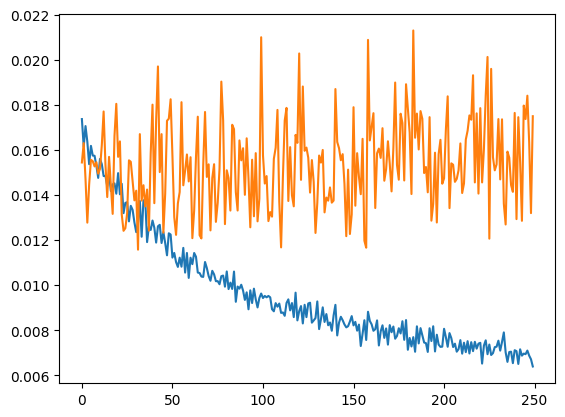

In [116]:
trainrnn(model,train_loader,test_loader,epochs = epochs,lr=1e-3,device='cpu',patience=5,factor=0.3,outmodelname = '../models/sequence_cnnrnn_test2.pkl')

In [125]:
model=joblib.load('../models/sequence_cnnrnn.pkl')
summary(model);

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            160
├─BatchNorm1d: 1-2                       40
├─MaxPool1d: 1-3                         --
├─RNN: 1-4                               1,728
├─Linear: 1-5                            9,605
Total params: 11,533
Trainable params: 11,533
Non-trainable params: 0


In [10]:
y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,val_loader)


              precision    recall  f1-score   support

           0      0.990     0.983     0.987     18118
           1      0.720     0.791     0.754       556
           2      0.904     0.956     0.929      1448
           3      0.747     0.784     0.765       162
           4      0.986     0.983     0.984      1608

    accuracy                          0.975     21892
   macro avg      0.869     0.899     0.884     21892
weighted avg      0.976     0.975     0.975     21892



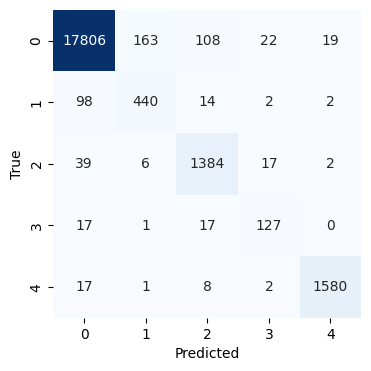

In [11]:
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

#### 3.2 Modèle CNN + RNN avec dropout

In [123]:
class CNNRNNdrop(nn.Module):
    
    def __init__(self,input_size,num_conv,hidden_size,num_layer,num_classes=10,dropout=0.5):
        super(CNNRNNdrop,self).__init__()
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.num_conv =num_conv
        self.cnn =  nn.Conv1d(in_channels=1, out_channels=self.num_conv , kernel_size=7, stride=1, padding=0) # shape: (batch_size, n, 181)
        self.batch = nn.BatchNorm1d(num_features=self.num_conv )
        self.pool= nn.MaxPool1d(3, stride=3) # shape: (batch_size, n, 60)
        self.rnn=nn.RNN(self.num_conv ,hidden_size,num_layer,batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc=nn.Linear(hidden_size*60,num_classes)


    def forward(self,x):
        h0=torch.zeros(self.num_layer,x.size(0),self.hidden_size).to("cpu")
        out=self.cnn(x)
        
        out=nn.ReLU()(out)
        out=self.batch(out)
        out=self.pool(out)
        out,_=self.rnn(out.swapaxes(1,2),h0)
        out=out.reshape(out.shape[0],-1)
        out = self.dropout(out)
        out=self.fc(out)
        
        return out


In [47]:
model = CNNRNNdrop(input_size,num_conv, hidden_size,num_layer,num_classes)


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.3312691115393845, --- Val loss 0.38322538137435913, --- accuray : 0.9293146180230739, --- recall : 0.9294541456738523


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.22004903872434867, --- Val loss 0.25324544310569763, --- accuray : 0.9444270883207201, --- recall : 0.9431461981605551


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.19167072413461675, --- Val loss 0.12699277698993683, --- accuray : 0.9530597249533835, --- recall : 0.9518822128075822


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.17269735525873944, --- Val loss 0.16428659856319427, --- accuray : 0.9570280495677626, --- recall : 0.9570756922105813


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 5/50 -- Training loss 0.16040331128437973, --- Val loss 0.18417248129844666, --- accuray : 0.9627155621217913, --- recall : 0.9625701002684448


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 6/50 -- Training loss 0.15430778406022183, --- Val loss 0.1363568753004074, --- accuray : 0.962047865609444, --- recall : 0.96208806646537


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 7/50 -- Training loss 0.14902255251003477, --- Val loss 0.12240060418844223, --- accuray : 0.9654387452231118, --- recall : 0.9654563490134412


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 8/50 -- Training loss 0.14033167697997834, --- Val loss 0.13591887056827545, --- accuray : 0.9660621674463726, --- recall : 0.9660411636957124


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 9/50 -- Training loss 0.13526953444990994, --- Val loss 0.11742636561393738, --- accuray : 0.9702484646760909, --- recall : 0.9703060860037273


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 10/50 -- Training loss 0.1319072403943969, --- Val loss 0.3029373288154602, --- accuray : 0.9592109580368234, --- recall : 0.957103392787916


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 11/50 -- Training loss 0.12729263678828806, --- Val loss 0.12207628786563873, --- accuray : 0.9682134753418931, --- recall : 0.9680938576666369


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 12/50 -- Training loss 0.1240724711329279, --- Val loss 0.11538064479827881, --- accuray : 0.966232715950262, --- recall : 0.9654361107377204


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 13/50 -- Training loss 0.12330568110330858, --- Val loss 0.11355895549058914, --- accuray : 0.9539950760047227, --- recall : 0.9475557738557592


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 14/50 -- Training loss 0.12117175449351267, --- Val loss 0.08316119015216827, --- accuray : 0.9689289804144698, --- recall : 0.9685985233964136


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 15/50 -- Training loss 0.11823791368897323, --- Val loss 0.07145249843597412, --- accuray : 0.9738903714427668, --- recall : 0.9738963772677909


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 16/50 -- Training loss 0.11638512184834945, --- Val loss 0.16974982619285583, --- accuray : 0.9690091759972018, --- recall : 0.9688598968699234


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 17/50 -- Training loss 0.11611292548784911, --- Val loss 0.31008753180503845, --- accuray : 0.9707744453068724, --- recall : 0.9702695917728711


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 18/50 -- Training loss 0.11497945259764909, --- Val loss 0.07430660724639893, --- accuray : 0.9696323686379079, --- recall : 0.9687796251856184


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 19/50 -- Training loss 0.11326305545862252, --- Val loss 0.10087520629167557, --- accuray : 0.9751550708379719, --- recall : 0.9749643342828442


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 20/50 -- Training loss 0.11059981777620914, --- Val loss 0.14692546427249908, --- accuray : 0.9737765842748276, --- recall : 0.9738270260985049


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 21/50 -- Training loss 0.11050420896991435, --- Val loss 0.11950357258319855, --- accuray : 0.9751123028889148, --- recall : 0.975160894320193


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 22/50 -- Training loss 0.10917053630986634, --- Val loss 0.09797903150320053, --- accuray : 0.9752902732259795, --- recall : 0.9752960509174556


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 23/50 -- Training loss 0.10686868356818395, --- Val loss 0.14093364775180817, --- accuray : 0.9682431226582132, --- recall : 0.9668000129058509


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 24/50 -- Training loss 0.10661312181447485, --- Val loss 0.07827020436525345, --- accuray : 0.9698106959155727, --- recall : 0.9696343422232563


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 25/50 -- Training loss 0.10676400743841286, --- Val loss 0.13486617803573608, --- accuray : 0.9748354513605484, --- recall : 0.9747566409262323


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 26/50 -- Training loss 0.10590678036257421, --- Val loss 0.19293667376041412, --- accuray : 0.9741900117644869, --- recall : 0.9735428072029897


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 27/50 -- Training loss 0.10328005141482198, --- Val loss 0.04029020294547081, --- accuray : 0.9750579751124956, --- recall : 0.9744352551282839


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 28/50 -- Training loss 0.10453691124170171, --- Val loss 0.03909052163362503, --- accuray : 0.9780818266287608, --- recall : 0.9781011793109377


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 29/50 -- Training loss 0.10305772420968246, --- Val loss 0.12439809739589691, --- accuray : 0.9752086362138158, --- recall : 0.9752324867866428


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 30/50 -- Training loss 0.10070392541667876, --- Val loss 0.17543131113052368, --- accuray : 0.9737980199166639, --- recall : 0.9733545624364754


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 31/50 -- Training loss 0.10123666674767508, --- Val loss 0.06286836415529251, --- accuray : 0.975971354152817, --- recall : 0.9755529109707519


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 32/50 -- Training loss 0.10212779859032173, --- Val loss 0.04565292224287987, --- accuray : 0.9783121625138493, --- recall : 0.9782814766531672


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 33/50 -- Training loss 0.09985103340956157, --- Val loss 0.0369916632771492, --- accuray : 0.9760584868708948, --- recall : 0.9761194234363882


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 34/50 -- Training loss 0.09880893339537533, --- Val loss 0.11444433033466339, --- accuray : 0.9784198639356422, --- recall : 0.9781991282452683


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 35/50 -- Training loss 0.0985519076131742, --- Val loss 0.038740966469049454, --- accuray : 0.9781934588618884, --- recall : 0.9781884393461613


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.09905443031238063, --- Val loss 0.07657930254936218, --- accuray : 0.974362833742456, --- recall : 0.9743593363689392


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 37/50 -- Training loss 0.09686999588111359, --- Val loss 0.10723908990621567, --- accuray : 0.9765218615593263, --- recall : 0.97629022885914


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 38/50 -- Training loss 0.0983507134413942, --- Val loss 0.3037140965461731, --- accuray : 0.9788636915547523, --- recall : 0.9788115679532972


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 39/50 -- Training loss 0.09741264321010631, --- Val loss 0.05454183369874954, --- accuray : 0.9785367121000954, --- recall : 0.97823811349102


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.09656117562139968, --- Val loss 0.10663522779941559, --- accuray : 0.9774183328298977, --- recall : 0.9774697892216867


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 41/50 -- Training loss 0.09719474867104942, --- Val loss 0.08525609225034714, --- accuray : 0.9778872794308044, --- recall : 0.9779086006665911


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 42/50 -- Training loss 0.09493802829917872, --- Val loss 0.15283137559890747, --- accuray : 0.9767356827325795, --- recall : 0.97602836167555


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 43/50 -- Training loss 0.09503195194375995, --- Val loss 0.056344807147979736, --- accuray : 0.9790333454948825, --- recall : 0.979035363103517


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 44/50 -- Training loss 0.09603357460112465, --- Val loss 0.10878770053386688, --- accuray : 0.9791583295524109, --- recall : 0.979100505060049


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 45/50 -- Training loss 0.0960642020774325, --- Val loss 0.06690718978643417, --- accuray : 0.9792062402530206, --- recall : 0.97905116590695


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 46/50 -- Training loss 0.09358222874737555, --- Val loss 0.12463442981243134, --- accuray : 0.9777343930753277, --- recall : 0.9777529878849412


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 47/50 -- Training loss 0.09391034448008657, --- Val loss 0.08048533648252487, --- accuray : 0.9753260297677147, --- recall : 0.9750436673976106


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 48/50 -- Training loss 0.09231604993199258, --- Val loss 0.18469855189323425, --- accuray : 0.9794834567562838, --- recall : 0.9794994737024915


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.09383173904909337, --- Val loss 0.08983985334634781, --- accuray : 0.9752568876615587, --- recall : 0.975279985071803


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 50/50 -- Training loss 0.09294449908468677, --- Val loss 0.16393613815307617, --- accuray : 0.9772869201384973, --- recall : 0.9773026914956027


CNNRNNdrop(
  (cnn): Conv1d(1, 20, kernel_size=(7,), stride=(1,))
  (batch): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (rnn): RNN(20, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1920, out_features=5, bias=True)
)

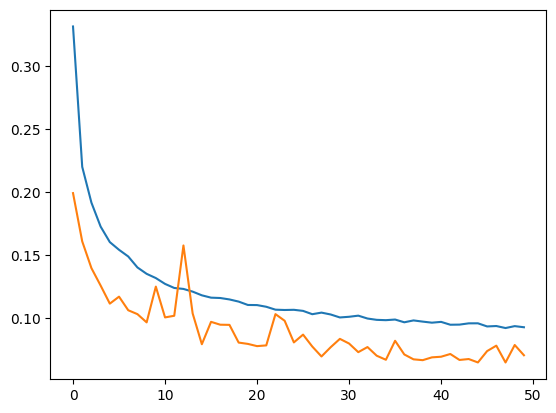

In [48]:
trainrnn(model,train_loader,test_loader,epochs = 50,lr=1e-3,device='cpu',patience=5,factor=0.3,outmodelname = '../models/sequence_cnnrnn_withdropout.pkl')

In [124]:
model=joblib.load('../models/sequence_cnnrnn_withdropout.pkl')
summary(model);

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            160
├─BatchNorm1d: 1-2                       40
├─MaxPool1d: 1-3                         --
├─RNN: 1-4                               1,728
├─Dropout: 1-5                           --
├─Linear: 1-6                            9,605
Total params: 11,533
Trainable params: 11,533
Non-trainable params: 0


              precision    recall  f1-score   support

           0      0.992     0.961     0.976     18118
           1      0.508     0.829     0.630       556
           2      0.898     0.955     0.926      1448
           3      0.521     0.907     0.662       162
           4      0.975     0.986     0.981      1608

    accuracy                          0.958     21892
   macro avg      0.779     0.928     0.835     21892
weighted avg      0.969     0.958     0.962     21892



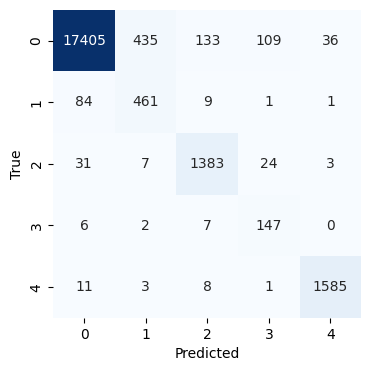

In [132]:
y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,val_loader)
print(classification_report(y_true, y_pred,digits=3))
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')

## 4. Application d'une couche GRU après une première couche de convolution

In [69]:
class CNNGRUdrop(nn.Module):
    
    def __init__(self,input_size,num_conv,hidden_size,num_layer,num_classes=10,dropout=0.4):
        super(CNNGRUdrop,self).__init__()
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.num_conv =num_conv
        self.cnn =  nn.Conv1d(in_channels=1, out_channels=self.num_conv , kernel_size=7, stride=1, padding=0) # shape: (batch_size, n, 181)
        self.batch = nn.BatchNorm1d(num_features=self.num_conv )
        self.pool= nn.MaxPool1d(3, stride=3) # shape: (batch_size, n, 60)
        self.gru=nn.GRU(self.num_conv ,hidden_size,num_layer,batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc=nn.Linear(hidden_size*60,num_classes)


    def forward(self,x):
        h0=torch.zeros(self.num_layer,x.size(0),self.hidden_size).to("cpu")
        out=self.cnn(x)
        
        out=nn.ReLU()(out)
        out=self.batch(out)
        out=self.pool(out)
        out,_=self.gru(out.swapaxes(1,2),h0)
        out=out.reshape(out.shape[0],-1)
        out = self.dropout(out)
        out=self.fc(out)
        
        return out



In [121]:
model = CNNGRUdrop(input_size,num_conv, hidden_size,num_layer,num_classes)
summary(model);

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            160
├─BatchNorm1d: 1-2                       40
├─MaxPool1d: 1-3                         --
├─GRU: 1-4                               5,184
├─Dropout: 1-5                           --
├─Linear: 1-6                            9,605
Total params: 14,989
Trainable params: 14,989
Non-trainable params: 0


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.27030549144988986, --- Val loss 0.08908018469810486, --- accuray : 0.9496110950662121, --- recall : 0.9484700230715862


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.13748364547422248, --- Val loss 0.08711694180965424, --- accuray : 0.9652158324497883, --- recall : 0.9648337777133047


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.10636902228580519, --- Val loss 0.05627189204096794, --- accuray : 0.9718397929895712, --- recall : 0.9717234187943479


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.09171439761791772, --- Val loss 0.04754495248198509, --- accuray : 0.976730433117388, --- recall : 0.9766351607291913


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 5/50 -- Training loss 0.08055318866944337, --- Val loss 0.0942666232585907, --- accuray : 0.978369956317372, --- recall : 0.9783370378973599


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 6/50 -- Training loss 0.07363252401530988, --- Val loss 0.0980575904250145, --- accuray : 0.9839235792240633, --- recall : 0.9839365921328209


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 7/50 -- Training loss 0.06803997648499516, --- Val loss 0.1432247757911682, --- accuray : 0.9806876239657927, --- recall : 0.9804824198406694


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 8/50 -- Training loss 0.06486070248620443, --- Val loss 0.21318688988685608, --- accuray : 0.9824471271296404, --- recall : 0.9822730717738951


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 9/50 -- Training loss 0.06021449726315446, --- Val loss 0.036169253289699554, --- accuray : 0.9843768344858382, --- recall : 0.9843738543469758


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 10/50 -- Training loss 0.057432204558973896, --- Val loss 0.08143949508666992, --- accuray : 0.9864256464422463, --- recall : 0.9864618787044661


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 11/50 -- Training loss 0.05487614331859142, --- Val loss 0.04501644894480705, --- accuray : 0.9834115135580206, --- recall : 0.9833609162049237


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 12/50 -- Training loss 0.052550807598696445, --- Val loss 0.011803223751485348, --- accuray : 0.9858762721229308, --- recall : 0.9858667259214269


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 13/50 -- Training loss 0.0508567633074062, --- Val loss 0.07172293961048126, --- accuray : 0.9866509804615393, --- recall : 0.9866058310050679


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 14/50 -- Training loss 0.04896581614149238, --- Val loss 0.12204141914844513, --- accuray : 0.9862924196400528, --- recall : 0.9863069537089914


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 15/50 -- Training loss 0.04782309459049024, --- Val loss 0.015256423503160477, --- accuray : 0.9883140700153745, --- recall : 0.9883316217682866


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 16/50 -- Training loss 0.0448036563074941, --- Val loss 0.007955264300107956, --- accuray : 0.9885151014393212, --- recall : 0.9885312708364008


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 17/50 -- Training loss 0.044553793569547584, --- Val loss 0.014315342530608177, --- accuray : 0.9889244103140925, --- recall : 0.9889336683239105


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 18/50 -- Training loss 0.04304158488407454, --- Val loss 0.03463137149810791, --- accuray : 0.9891793110300249, --- recall : 0.9891622499345448


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 19/50 -- Training loss 0.04146367563789495, --- Val loss 0.07310759276151657, --- accuray : 0.9883956599692709, --- recall : 0.9883232983136125


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 20/50 -- Training loss 0.04110708262716273, --- Val loss 0.018415477126836777, --- accuray : 0.9885046532129971, --- recall : 0.9885343185895611


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 21/50 -- Training loss 0.03970547598877275, --- Val loss 0.015042253769934177, --- accuray : 0.9885892070013413, --- recall : 0.9885869067394338


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 22/50 -- Training loss 0.039126821436290975, --- Val loss 0.08525621145963669, --- accuray : 0.9896926153143, --- recall : 0.9896391887967122


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 23/50 -- Training loss 0.038734762559340795, --- Val loss 0.039322078227996826, --- accuray : 0.9903675456893681, --- recall : 0.9903777106587078


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 24/50 -- Training loss 0.03746168821861963, --- Val loss 0.06820516288280487, --- accuray : 0.9902106721595676, --- recall : 0.9902205212147068


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 25/50 -- Training loss 0.037032169707132905, --- Val loss 0.016535121947526932, --- accuray : 0.9890825688908247, --- recall : 0.9890971051426822


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 26/50 -- Training loss 0.03575780904278783, --- Val loss 0.022874660789966583, --- accuray : 0.9892084790532578, --- recall : 0.9891157374906119


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 27/50 -- Training loss 0.03506711155389028, --- Val loss 0.16645310819149017, --- accuray : 0.988848184457134, --- recall : 0.9888584054008245


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 28/50 -- Training loss 0.0347191250427745, --- Val loss 0.0167445819824934, --- accuray : 0.9915674041687075, --- recall : 0.9915743967570357


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 29/50 -- Training loss 0.03314809960002601, --- Val loss 0.004661682993173599, --- accuray : 0.9913212556468348, --- recall : 0.991330265129785


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 30/50 -- Training loss 0.033990996904181225, --- Val loss 0.0094774654135108, --- accuray : 0.9901233718780812, --- recall : 0.9901323280095271


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 31/50 -- Training loss 0.03215616481848243, --- Val loss 0.10286032408475876, --- accuray : 0.9897288652928016, --- recall : 0.9897046767232451


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 32/50 -- Training loss 0.03272816553734307, --- Val loss 0.0007193920901045203, --- accuray : 0.9910955927683943, --- recall : 0.9910984497762796


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 33/50 -- Training loss 0.031594437809277086, --- Val loss 0.015624241903424263, --- accuray : 0.9912519974540448, --- recall : 0.991248254554517


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 34/50 -- Training loss 0.03127469188323871, --- Val loss 0.003655092092230916, --- accuray : 0.9915644121174308, --- recall : 0.9915761084905288


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 35/50 -- Training loss 0.030941078244228447, --- Val loss 0.006013497244566679, --- accuray : 0.9900817233248539, --- recall : 0.9900396043574908


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.030236401726821262, --- Val loss 0.015619739890098572, --- accuray : 0.9888642658769953, --- recall : 0.988870763215995


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 37/50 -- Training loss 0.031239446245825846, --- Val loss 0.01625935547053814, --- accuray : 0.9909930221424353, --- recall : 0.991017063113147


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 38/50 -- Training loss 0.029662022820902807, --- Val loss 0.011467566713690758, --- accuray : 0.9925194491251664, --- recall : 0.9925281125664794


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 39/50 -- Training loss 0.030360523308547844, --- Val loss 0.019602883607149124, --- accuray : 0.9916341978582492, --- recall : 0.9916584257632326


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.029311955587003925, --- Val loss 0.06503873318433762, --- accuray : 0.9922179219981464, --- recall : 0.9922184595106499


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 41/50 -- Training loss 0.028493829349804375, --- Val loss 0.0011042981641367078, --- accuray : 0.9921578958465735, --- recall : 0.992171180538775


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 42/50 -- Training loss 0.028891821424502296, --- Val loss 0.003973579965531826, --- accuray : 0.9899722621147922, --- recall : 0.9899757080892412


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 43/50 -- Training loss 0.02792285804580605, --- Val loss 0.0003887329366989434, --- accuray : 0.9928172776952368, --- recall : 0.9928182486265253


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 44/50 -- Training loss 0.02820665821000831, --- Val loss 0.02624920755624771, --- accuray : 0.9913644868889687, --- recall : 0.9913707812469736


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 45/50 -- Training loss 0.028546347697088803, --- Val loss 0.008320205844938755, --- accuray : 0.9928529457927532, --- recall : 0.9928447705721208


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 46/50 -- Training loss 0.028319176376228373, --- Val loss 0.09510074555873871, --- accuray : 0.9910578050602268, --- recall : 0.9910439463886572


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 47/50 -- Training loss 0.02684084512416674, --- Val loss 0.0016845798818394542, --- accuray : 0.9921988714168407, --- recall : 0.992207470551447


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 48/50 -- Training loss 0.027288800169698663, --- Val loss 0.006246740929782391, --- accuray : 0.9911348285740573, --- recall : 0.9911254921590867


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.027594623809701666, --- Val loss 0.0012469538487493992, --- accuray : 0.9926335126121385, --- recall : 0.9926540236750535


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 50/50 -- Training loss 0.026161166372208285, --- Val loss 0.0008852535393089056, --- accuray : 0.991003586116465, --- recall : 0.9909857704011564


CNNGRUdrop(
  (cnn): Conv1d(1, 20, kernel_size=(7,), stride=(1,))
  (batch): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(20, 32, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=1920, out_features=5, bias=True)
)

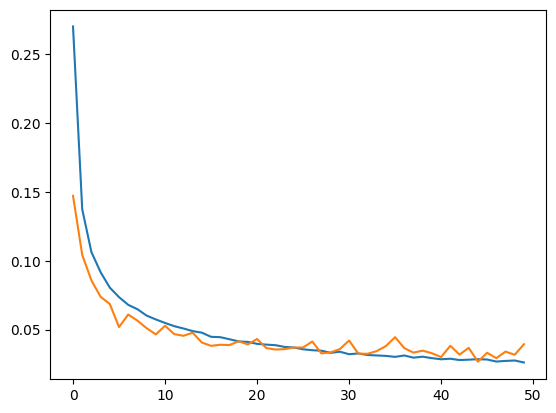

In [76]:
trainrnn(model,train_loader,test_loader,epochs = 50,lr=1e-3,device='cpu',patience=5,factor=0.3,outmodelname = '../models/sequence_cnngru_withdropout.pkl')

In [120]:
model=joblib.load('../models/sequence_cnngru_withdropout.pkl')
summary(model);

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            160
├─BatchNorm1d: 1-2                       40
├─MaxPool1d: 1-3                         --
├─GRU: 1-4                               5,184
├─Dropout: 1-5                           --
├─Linear: 1-6                            9,605
Total params: 14,989
Trainable params: 14,989
Non-trainable params: 0


              precision    recall  f1-score   support

           0      0.993     0.990     0.991     18118
           1      0.809     0.847     0.828       556
           2      0.956     0.957     0.957      1448
           3      0.766     0.809     0.787       162
           4      0.980     0.993     0.987      1608

    accuracy                          0.983     21892
   macro avg      0.901     0.919     0.910     21892
weighted avg      0.983     0.983     0.983     21892



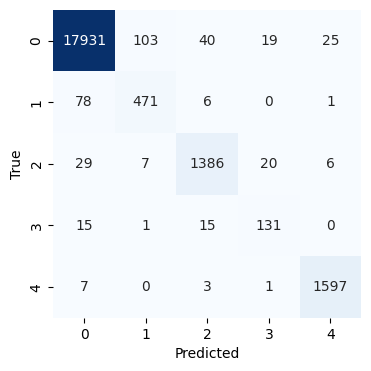

In [135]:
y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,val_loader)
print(classification_report(y_true, y_pred,digits=3))
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')

## Test d'un modèle plus lourd

In [111]:
class biggru(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_layer,num_classes=10,dropout=0.4):
        super(biggru,self).__init__()
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.block1 =  nn.Sequential(
                        nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=0), # shape: (batch_size, n, 181)
                        nn.ReLU(),
                        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 177)
                        nn.ReLU(),
                        nn.BatchNorm1d(num_features=64),
                        nn.MaxPool1d(3, stride=3)) # shape: (batch_size, n, 59)
        self.gru=nn.GRU(64 ,hidden_size,num_layer,batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1=nn.Linear(hidden_size*59*2,48)
        self.fc2=nn.Linear(48,5)


    def forward(self,x):
        h0=torch.zeros(2*self.num_layer,x.size(0),self.hidden_size).to("cpu")
        out=self.block1(x)
        out,_=self.gru(out.swapaxes(1,2),h0)
        out=out.reshape(out.shape[0],-1)
        out = self.dropout(out)
        out=nn.ReLU()(self.fc1(out))
        out=self.fc2(out)
        
        return out


In [112]:
model = biggru(input_size, 8,num_layer,num_classes=5)

In [113]:
summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       256
|    └─ReLU: 2-2                         --
|    └─Conv1d: 2-3                       10,304
|    └─ReLU: 2-4                         --
|    └─BatchNorm1d: 2-5                  128
|    └─MaxPool1d: 2-6                    --
├─GRU: 1-2                               3,552
├─Dropout: 1-3                           --
├─Linear: 1-4                            45,360
├─Linear: 1-5                            245
Total params: 59,845
Trainable params: 59,845
Non-trainable params: 0


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.1643647209543044, --- Val loss 0.17584723234176636, --- accuray : 0.9656001756921437, --- recall : 0.9654435657578635


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.09342045370442739, --- Val loss 0.07153291255235672, --- accuray : 0.9764276012256307, --- recall : 0.9763723322604971


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.07079441991737441, --- Val loss 0.07760205864906311, --- accuray : 0.9829698996824255, --- recall : 0.9829705245033586


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.06064739831102391, --- Val loss 0.10678397864103317, --- accuray : 0.9850592244247742, --- recall : 0.9850363188934802


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 5/50 -- Training loss 0.052144900042207676, --- Val loss 0.07087849825620651, --- accuray : 0.9878935922198668, --- recall : 0.9878923545484671


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 6/50 -- Training loss 0.04861824125299427, --- Val loss 0.03938019648194313, --- accuray : 0.98881045335786, --- recall : 0.9887821342066389


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 7/50 -- Training loss 0.04344708060189357, --- Val loss 0.030172137543559074, --- accuray : 0.9894472340161714, --- recall : 0.9894475496264917


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 8/50 -- Training loss 0.0412575251158471, --- Val loss 0.007169832941144705, --- accuray : 0.991059699486042, --- recall : 0.9910499332087197


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 9/50 -- Training loss 0.037557032945978036, --- Val loss 0.12278223037719727, --- accuray : 0.9906236096322708, --- recall : 0.9906203314516132


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 10/50 -- Training loss 0.03706389973753273, --- Val loss 0.007226031739264727, --- accuray : 0.9912809640473931, --- recall : 0.9912624636221661


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 11/50 -- Training loss 0.03483695745849834, --- Val loss 0.015971790999174118, --- accuray : 0.9922099789759559, --- recall : 0.9922070583899331


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 12/50 -- Training loss 0.03348681592165023, --- Val loss 0.008195542730391026, --- accuray : 0.9915057839437749, --- recall : 0.991489967496394


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 13/50 -- Training loss 0.03241259923576408, --- Val loss 0.00891166739165783, --- accuray : 0.9921494571058609, --- recall : 0.9921335700398464


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 14/50 -- Training loss 0.030653275751019535, --- Val loss 0.07147006690502167, --- accuray : 0.9934054613553215, --- recall : 0.9934047234632584


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 15/50 -- Training loss 0.02997826419130897, --- Val loss 0.07601995766162872, --- accuray : 0.9930873891311307, --- recall : 0.9930909903464469


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 16/50 -- Training loss 0.029949097191567655, --- Val loss 0.022829102352261543, --- accuray : 0.9922652646876869, --- recall : 0.9922507991717333


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 17/50 -- Training loss 0.028703469883424596, --- Val loss 0.023968765512108803, --- accuray : 0.9931783442813952, --- recall : 0.993170441044825


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 18/50 -- Training loss 0.028333225982181305, --- Val loss 0.057814452797174454, --- accuray : 0.993054631814718, --- recall : 0.9930563987183039


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 19/50 -- Training loss 0.026900585018605868, --- Val loss 0.003241626312956214, --- accuray : 0.9924609621489008, --- recall : 0.9924571797772869


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 20/50 -- Training loss 0.02621396401784101, --- Val loss 0.01978057250380516, --- accuray : 0.993576758307905, --- recall : 0.9935724728202251


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 21/50 -- Training loss 0.02603517270258806, --- Val loss 0.09989246726036072, --- accuray : 0.9932215960208609, --- recall : 0.9932162823086251


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 22/50 -- Training loss 0.02551241036863355, --- Val loss 0.004116090014576912, --- accuray : 0.9939438006776274, --- recall : 0.993929956713206


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 23/50 -- Training loss 0.024610243034545416, --- Val loss 0.04075700417160988, --- accuray : 0.9936897214497549, --- recall : 0.9936902513024487


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 24/50 -- Training loss 0.024241871378535246, --- Val loss 0.04979964345693588, --- accuray : 0.9925513865964939, --- recall : 0.9925372546801953


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 25/50 -- Training loss 0.023991123669390355, --- Val loss 0.051940254867076874, --- accuray : 0.9940896423435722, --- recall : 0.9940849926800691


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 26/50 -- Training loss 0.02351519443347096, --- Val loss 0.027981329709291458, --- accuray : 0.9936269028741258, --- recall : 0.9936154652408579


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 27/50 -- Training loss 0.02405975950891176, --- Val loss 0.04941636696457863, --- accuray : 0.9926077006974119, --- recall : 0.9926062577712729


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 28/50 -- Training loss 0.022964487658868295, --- Val loss 0.0008494367357343435, --- accuray : 0.9942788356284581, --- recall : 0.9942880676321796


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 29/50 -- Training loss 0.022537921257828948, --- Val loss 0.01087303925305605, --- accuray : 0.9944537575262254, --- recall : 0.99445685972654


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 30/50 -- Training loss 0.02203076434626249, --- Val loss 0.014180053025484085, --- accuray : 0.9948177279884407, --- recall : 0.9948091347046588


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 31/50 -- Training loss 0.021477860255173908, --- Val loss 0.020387133583426476, --- accuray : 0.9954793124474843, --- recall : 0.9954868296295057


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 32/50 -- Training loss 0.021567743797618666, --- Val loss 0.027101485058665276, --- accuray : 0.9951364913139116, --- recall : 0.9951268421118517


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 33/50 -- Training loss 0.02032775990839615, --- Val loss 0.0013427353696897626, --- accuray : 0.9940958841913725, --- recall : 0.9940904659640797


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 34/50 -- Training loss 0.021137053737991258, --- Val loss 0.0018264279933646321, --- accuray : 0.9941280656607745, --- recall : 0.9941252625217508


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 35/50 -- Training loss 0.019920068592682322, --- Val loss 0.014514277689158916, --- accuray : 0.9946856482118138, --- recall : 0.9946876725565801


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.019748415158674426, --- Val loss 0.0292129535228014, --- accuray : 0.994296895244881, --- recall : 0.9942933088151744


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 37/50 -- Training loss 0.020331263690968212, --- Val loss 0.03196379542350769, --- accuray : 0.9950512067526784, --- recall : 0.9950510185205893


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 38/50 -- Training loss 0.0200309222196744, --- Val loss 0.06366704404354095, --- accuray : 0.9953189872436056, --- recall : 0.9953310360804078


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 39/50 -- Training loss 0.019242326004317547, --- Val loss 0.03288014978170395, --- accuray : 0.9956901701122766, --- recall : 0.9956928332084314


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.017998805370535283, --- Val loss 0.004970565438270569, --- accuray : 0.9951605369376759, --- recall : 0.995166469512554


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 41/50 -- Training loss 0.018698432212575288, --- Val loss 0.026349464431405067, --- accuray : 0.9959257357730638, --- recall : 0.9959302329289799


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 42/50 -- Training loss 0.018224561672934163, --- Val loss 0.0036556674167513847, --- accuray : 0.995237602036266, --- recall : 0.9952496924770496


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 43/50 -- Training loss 0.018422225440294735, --- Val loss 0.004170515108853579, --- accuray : 0.9955231677191685, --- recall : 0.9955303726927822


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 44/50 -- Training loss 0.018131101808035392, --- Val loss 0.01081043016165495, --- accuray : 0.9961612814328442, --- recall : 0.9961696311370103


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 45/50 -- Training loss 0.017297929568906537, --- Val loss 0.014396443963050842, --- accuray : 0.9957272869876684, --- recall : 0.995730492776827


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 46/50 -- Training loss 0.018236649828078842, --- Val loss 0.002599093597382307, --- accuray : 0.9946564181154619, --- recall : 0.9946558687331544


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 47/50 -- Training loss 0.017539995512156934, --- Val loss 0.0064956070855259895, --- accuray : 0.995650783030927, --- recall : 0.9956521345086111


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 48/50 -- Training loss 0.016785211600134464, --- Val loss 0.037332601845264435, --- accuray : 0.9962431983851257, --- recall : 0.9962486565861421


train:   0%|          | 0/1758 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.01652736532102336, --- Val loss 0.0024689880665391684, --- accuray : 0.9957249891649582, --- recall : 0.995727930207155


train:   0%|          | 0/1758 [00:00<?, ?it/s]

save model
Epoch : 50/50 -- Training loss 0.016890305758178212, --- Val loss 0.003914011642336845, --- accuray : 0.9967611340702467, --- recall : 0.9967666839487735


biggru(
  (block1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(64, 8, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=944, out_features=48, bias=True)
  (fc2): Linear(in_features=48, out_features=5, bias=True)
)

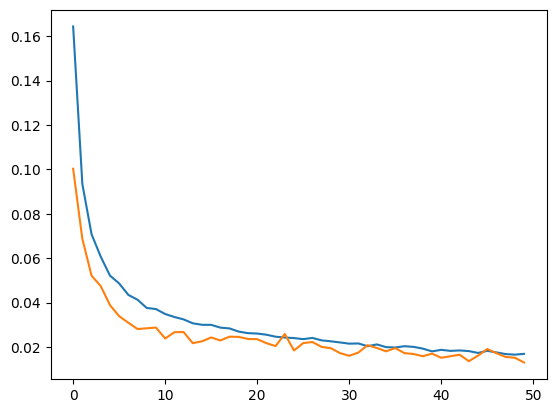

In [115]:
trainrnn(model,train_loader,test_loader,epochs = 50,lr=1e-3,device='cpu',patience=5,factor=0.3,outmodelname = '../models/sequence_conv2grubidir.pkl')

              precision    recall  f1-score   support

           0      0.993     0.991     0.992     18118
           1      0.849     0.838     0.843       556
           2      0.954     0.964     0.959      1448
           3      0.745     0.864     0.800       162
           4      0.989     0.991     0.990      1608

    accuracy                          0.984     21892
   macro avg      0.906     0.930     0.917     21892
weighted avg      0.985     0.984     0.984     21892



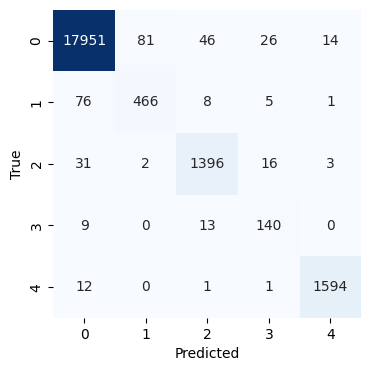

In [117]:
model=joblib.load('../models/sequence_conv2grubidir.pkl')
y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,val_loader)
print(classification_report(y_true, y_pred,digits=3))
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')

In [119]:
summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       256
|    └─ReLU: 2-2                         --
|    └─Conv1d: 2-3                       10,304
|    └─ReLU: 2-4                         --
|    └─BatchNorm1d: 2-5                  128
|    └─MaxPool1d: 2-6                    --
├─GRU: 1-2                               3,552
├─Dropout: 1-3                           --
├─Linear: 1-4                            45,360
├─Linear: 1-5                            245
Total params: 59,845
Trainable params: 59,845
Non-trainable params: 0


## help RNN

torch.nn.RNN has two inputs:
 * input 
 * h_0 :  t=0. If we don't initialize the hidden layer, it will be auto-initiliased by PyTorch to be all zeros

input is the sequence which is fed into the network. It should be of size **(batch_size, number_of_time_sample, number_of_features)**

h_n is the hidden value from the last time-step of all RNN layers. It is of the size **(num_layers * num_directions, batch, hidden_size)**

torch.nn.RNN has two outputs 
* out 
* h_n.

out is the output of the RNN from all timesteps from the last RNN layer. the output size is **(batch_size, number_of_time_sample, num_directions * hidden_size)**.
h_n is the hidden value from the last time-step of all RNN layers. It is of the size **(num_layers * num_directions, batch, hidden_size)**.

The following diagram explains it more clearly. Here the batch=1. The diagram is for an LSTM which as two hidden parameters (h, c). RNN and GRU both have only h

<img src='1_tUxl5-C-t3Qumt0cyVhm2g.webp'>